## Code Summary

## 1) Code premises

- #### 1.1) Heston Model

- #### 1.2) Packages and utils

- #### 1.3) Default parameters

## 2) Heston paths

### 2.1) Function definitions

- #### 2.1.1) Core generation processes
- #### 2.1.2) parameters and function calls management
- #### 2.1.3) Paths generation 
- #### 2.1.4) Paths Visualization 

### 2.2) Application

## 3) Model analysis

### 3.1) Function definitions

- #### 3.1.1) Core metric evaluation processes
- #### 3.1.2) Pathwise metrics
- #### 3.1.3) Scheme comparison
- #### 3.1.4) Metrics visualization

### 3.2) Application

## 4) Model Testing 

### 4.1) Testing routine definition

### 4.2) Testing

# 1) Code Premises

## 1.1) Heston Model

### Heston model differential equation

$\begin{eqnarray}
\left \{
\begin{array}{ccc}
dS(t)&=& r S(t)dt + \sqrt{v(t)} S(t) dW^s(t)\\
dv(t)&=& k(\theta-v(t))dt + \sigma \sqrt{v(t)} dW^v(t)\\
dW^s(t)dW^v(t)&=&\rho dt
\end{array}
\right .
\end{eqnarray}$

Where the second equation is an Orstein Ulembech process, and $W^s, W^t$ are correlated Wiener processes.

The parameters are:

- $r$ risk-neutral rate of return

- $\theta$ long run average variance

- $k$ the rate at which $v(t)$ reverts to $\theta$

- $\sigma$ volatility of the variance

__Underlying Wiener processes__

The correlation of the stochastic component of the two SDE above, can be interpreted as:

$\begin{eqnarray}
\left \{
\begin{array}{ccc}
Z^s_t&=& \rho Z^v_t + \sqrt{1-\rho^2} Z_2\\
Z^v_t&=& Z_1
\end{array}
\right .
\end{eqnarray}$

Where $Z_1,Z_2$ are two independent sample from a standard normal distribution $Z_{1,2} \sim N(0,1)$. These two quantity will represent the stochastic process underlying all the different discretization scheme that we will provide. These sample will be independent and identically distributed at any time t, so $Z^s_t\equiv Z_s$ and $ Z^v_t\equiv Z_v$.

### Heston model difference equations

__Euler scheme__

Applying Euler discretization schemes, we can reduce the differential eq. above to a set of discrete difference equations:

$\begin{eqnarray}
\left \{
\begin{array}{ccc}
v_{t+1}&=& v_t + k(\theta-v_t^+)\Delta t + \sigma \sqrt{v_t^+} Z_v \sqrt{\Delta t}\\
S_{t+1}&=& S_t + r S_t \Delta t + S_t \sqrt{v^+_t}  Z_s \sqrt{\Delta t}\\
\end{array}
\right .
\end{eqnarray}$

Where the notation $x^+$ stands for $max(x,0)$ which we need to set to avoid negative values.

__Log-Euler scheme__

$\begin{eqnarray}
\left \{
\begin{array}{ccc}
v_{t+1}&=& v_t + k(\theta-v_t^+)\Delta t + \sigma \sqrt{v_t^+} Z_v \sqrt{\Delta t}\\
S_{t+1}&=& S_te^ {(r - \frac{1}{2} v^+_t)\Delta t + \sqrt{v_t^+} Z_s \sqrt{\Delta t}}\\
\end{array}
\right .
\end{eqnarray}$

__Milstein scheme__

$\begin{eqnarray}
\left \{
\begin{array}{ccc}
v_{t+1}&=& v_t + k(\theta-v_t^+)\Delta t + \sigma \sqrt{v_t^+} Z_v\sqrt{\Delta t}+\frac{1}{4}\sigma^2(Z_v^2-1)\Delta t\\
S_{t+1}&=& S_t + r S_t \Delta t + S_t \sqrt{v^+_t}  Z^s_t \sqrt{\Delta t}+\frac{1}{2}S_t v_t^+ (Z_s^2-1)\Delta t\\
\end{array}
\right .
\end{eqnarray}$

## 1.2) Packages and utils

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
try:
    from tqdm.notebook import tqdm
except:
    tqdm=lambda x,**kw: x    
    
from time import time

from scipy.optimize import leastsq as LSQ

In [2]:
############################
# TIMERS
############################

# use decorator @timer_decorator(timer_name) to assign a timer to a function
# the timer will be a slot named {timer_name} where the time values are updated at every call of the function
# all slots are reset only by "reset_timers()" so the timer management is up to the user (front-end)
# use "dir_timers()" to see the timer values since last reset (only non empty ones are displayed)
#
# the correct use of these timers is:
# reset_timers()
# ...
# process involving timed functions
# ...
# dir_timers()
# this will print what function has been called during the process 
# (if function was decorated with timed decorator)
# and the total time the function took to execute

# the timer are classificated as:
#   (calc) timed function: **only manages computations**
#   (mtr_) timed function: manages metric evaluation processes
#   (tech) timed function: manages technical operations: parameters and data management
#   (oth_) timed function: manages other kind of operations: plotting, printing,....
#   (tot_) timed function: manages a combination of all operations
# so the interesting ones are mostly (calc) timed functions

TEMP_TIMERS={}

MAIN_START=time()

def reset_timers():
#     global TIMERS
    global TEMP_TIMERS
#     TIMERS=deepcopy(TEMP_TIMERS)
    for timer_name in TEMP_TIMERS:
        TEMP_TIMERS[timer_name]=0

def dir_timers(timer_name='all'):
    if timer_name=='all':
        print("  Latest run timer info:")
        print()
    #     for timer_name, time in TIMERS.items():
        for timer_name, time in TEMP_TIMERS.items():
            if time>0.:
                print("    {:_<55}:{:_>20.6f} sec".format(timer_name, time))
    else:
        print("    {:_<55}:{:_>20.6f} sec".format(timer_name, TEMP_TIMERS[timer_name]) )
    
def timer_decorator(timer_name='auto'):
    global TEMP_TIMERS
    if timer_name=='auto':
        name='timer_'+str(len(TEMP_TIMERS))
    if timer_name not in TEMP_TIMERS:
        TEMP_TIMERS[timer_name]=0.
#     if timer_name not in TIMERS:
#         TIMERS[timer_name]=0.
    def timer(func):
        def inner(*args, **kwargs):
            start=time()
            to_return=func(*args, **kwargs)
            end=time()
#             TIMERS[timer_name]+=end-start
            TEMP_TIMERS[timer_name]+=end-start
            return to_return
        return inner 
    return timer

## 1.3)  Default parameters

These parameters will be used any time that no other parametrization is specified

In [3]:
######################################
#System parameters (description below) 
######################################

PAR={
    'rho'  :-0.6,     
    #correlation between Z^s and Z^v underlying wiener processes
    'r'    :0.05,      
    #drift coefficient of prices
    'k'    :2.,      
    #k(1-theta)v_t
    'theta':0.1,      
    #k(1-theta)v_t  
    'sigma':0.57,          
    #variance of volatiliy
    'delta_t':0.0001,
    #"size" of time interval in term of "fraction of a day"
    #    so calling a simulation of N_steps means its lenght is N_step*PAR['delta_t'] days
    'S0'   :100.,
    #initial stock price
    'V0'   :0.1
    #initial volatility price
}

SETTING={
    'scheme':'euler',
    #which functions are used as the discretized version of the system
    'n_iter':int(10/PAR['delta_t'])
}

DEBUG=False
# prints variable during iteration
MAX_ARRAY_MB=500
# maximum size allowed (in Mbytes) for paths tensor

def print_parameters(to_test=[]):
    print("  {:-<31}".format("SYSTEM PARAMETERS"))
    for par_name, par_val in PAR.items():
        if par_name not in to_test:
            print(f"  {par_name:_<20}:{par_val:_>10}")
        else:
            print(f"  {par_name:_<20}:{'to_test':_>10}")
        
def print_settings(to_test=[]):
    print("  {:#<31}".format("SYSTEM SETTINGS"))
    for par_name, par_val in SETTING.items():
        if par_name not in to_test:
            print(f"  {par_name:_<20}:{par_val:_>10}")
        else:
            print(f"  {par_name:_<20}:{'to_test':_>10}")

def print_system(to_test=[]):
    print_settings(to_test=to_test)
    print()
    print_parameters(to_test=to_test)
    
def feller_condition(par=None):
    if par is None:
        par=PAR
    if 2*par['k']*par['theta']>par['sigma']**2:
        print("  2* k * theta > sigma **2 ")
        print("  ==> Feller condition Verified")
        print("     ==> volatility from Heston SDE never <0")
    else:
        print("  2* k * theta < sigma **2 ")
        print("  ==> Feller condition NOT Verified")
        print("     ==> volatility from Heston SDE can be <0")


print_system()
print()
feller_condition()

  SYSTEM SETTINGS################
  scheme______________:_____euler
  n_iter______________:____100000

  SYSTEM PARAMETERS--------------
  rho_________________:______-0.6
  r___________________:______0.05
  k___________________:_______2.0
  theta_______________:_______0.1
  sigma_______________:______0.57
  delta_t_____________:____0.0001
  S0__________________:_____100.0
  V0__________________:_______0.1

  2* k * theta > sigma **2 
  ==> Feller condition Verified
     ==> volatility from Heston SDE never <0


# 2) Heston paths generation

## 2.1) Function definitions

### 2.1.1) Core generation processes

In [4]:
##############################
# Wiener processes generation
##############################

@timer_decorator('(calc)_wiener_process_sampling')
def generate_sequence_corrwien(**par):
    """
    gemerates a single couple Zs,Zv sequence
    
    takes rho and n_iter from global parameters, stored in PAR and SETTING 
        unless they are provided to this function through keyword arguments
        
    returns generated sequences as a list of lists [time:SorV]
    """
    #decide parameters
    rho=par.get('rho', PAR['rho'])
    n_iter=par.get('n_iter', SETTING['n_iter'])
    Z_12 = np.random.normal(0,1,size=2*n_iter).reshape(n_iter,2)
    Z_v=Z_12[:,0]
    Z_s=rho*Z_v+(1-rho**2)**(1/2)*Z_12[:,1]
    return list(zip(Z_s, Z_v))

In [5]:
##########################
#next iter calc. (SCHEMES)
##########################
#all of these are thought to be BACK-END
#   and are not thought to be called on their own
#   this is why Z_sv_t and par are REQUIRED parameters
#   ( and "_" prefix means "if you want to call it be careful")
#in use case scenario the behaviour of these function is
#   managed by "generate_sequence" and "generate_paths" (front-end functions)
#   so user should only interact with those

def _nt_next_iter_euler(SV_t, Z_sv_t, par):
    Z_s_t, Z_v_t=Z_sv_t    
    S_t, V_t=SV_t
    if hasattr(V_t, '__iter__'):
        V_t_pos=np.maximum(np.zeros(len(V_t)), V_t)
    else:
        V_t_pos=max(0.,V_t)
        
    S_next=S_t + par['r']*S_t*par['delta_t'] + S_t*V_t_pos**(1/2)*Z_s_t*par['delta_t']**(1/2)
    V_next=V_t + par['k']*(par['theta']-V_t_pos)*par['delta_t'] + par['sigma']*V_t_pos**(1/2)* Z_v_t*par['delta_t']**(1/2)
    return S_next, V_next

@timer_decorator('(calc)_euler_scheme')
def _next_iter_euler(SV_t, Z_sv_t, par):
    return _nt_next_iter_euler(SV_t, Z_sv_t, par)

@timer_decorator('(calc)_logeuler_scheme')
def _next_iter_log_euler(SV_t, Z_sv_t, par):
    Z_s_t, Z_v_t=Z_sv_t    
    S_t, V_t=SV_t
    if hasattr(V_t, '__iter__'):
        V_t_pos=np.maximum(np.zeros(len(V_t)), V_t)
    else:
        V_t_pos=max(0.,V_t)
        
    S_next=S_t*np.exp( (par['r']-0.5*V_t_pos)*par['delta_t'] + V_t_pos**(1/2)*Z_s_t*par['delta_t']**(1/2) )
    V_next=V_t + par['k']*(par['theta']-V_t_pos)*par['delta_t'] + par['sigma']*V_t_pos**(1/2)* Z_v_t*par['delta_t']**(1/2)

    return S_next, V_next

@timer_decorator('(calc)_milstein_scheme')
def _next_iter_milstein(SV_t, Z_sv_t, par):
    Z_s_t, Z_v_t=Z_sv_t  
    S_t, V_t= _nt_next_iter_euler(SV_t, Z_sv_t, par)
    if hasattr(V_t, '__iter__'):
        V_t_pos=np.maximum(np.zeros(len(V_t)), V_t)
    else:
        V_t_pos=max(0.,V_t)
    
    S_next=S_t +  1/2*S_t*V_t_pos*(Z_s_t**2-1)*par['delta_t']    #<--- milston correction to euler
    V_next=V_t +  1/4*par['sigma']**2*(Z_v_t**2-1)*par['delta_t']#<--- milston correction to euler

    return S_next, V_next

_implemented_schemes=['euler','logeuler', 'milstein']

### 2.1.2) parameters and function calls management

In [6]:
###############################################
# parameters management, processes initializers
###############################################

@timer_decorator('(tech)_data_retrieving')
def _retrieve_parameters(**par_and_settings):
    par={}
    for par_name, par_val in PAR.items():
        par[par_name]=par_and_settings.get(par_name, par_val) 
    sett={}
    for par_name, par_val in SETTING.items():
        sett[par_name]=par_and_settings.get(par_name, par_val)      
    return par, sett

@timer_decorator('(tech)_data_retrieving')
def _retrieve_scheme(par, sett):
    if not isinstance(sett['scheme'], str):
        raise TypeError(f"sett['scheme'] parameter should be string, provided {sett['scheme']}")
    if   sett['scheme'].lower() =='euler':
        next_iter=lambda sv, z_sv_t: _next_iter_euler(sv, z_sv_t, par)
    elif sett['scheme'].lower() =='logeuler': 
        next_iter=lambda sv, z_sv_t: _next_iter_log_euler(sv, z_sv_t, par)
    elif sett['scheme'].lower() =='milstein':
        next_iter=lambda sv, z_sv_t: _next_iter_milstein(sv, z_sv_t, par)
    else:
        raise ValueError(f" scheme: {sett['scheme']} not implemented") 
    return next_iter

@timer_decorator('(tech)_data_retrieving')
def  _retrieve_wiener(Z_sv, par, sett):
    # if no Z_sv is provided, the function runs try to fetch 
    # or build a new wiener sequence local instance    
    if isinstance(Z_sv, str) and 'fetch' in Z_sv.lower():
        try: 
            Z_sv=Z_SV
        except:
            if 'new' in Z_sv.lower():
                pass
            else:
                raise ValueError("No Z_sv found in global scope") 
    if isinstance(Z_sv, str) and 'new' in Z_sv.lower():        #builds new Z_sv
        Z_sv=generate_sequence_corrwien(**par) 
    #checking Z_sv is correct type and lenght
    if not hasattr(Z_sv, '__iter__'):
        raise TypeError(f"Error: Z_sv must be iterable")
    if sett['n_iter']>len(Z_sv):
        raise ValueError(f" WARNING: {sett['n_iter']=}>{len(Z_sv)=}")
   
    return Z_sv

### 2.1.3) Paths generation

In [7]:
########################
# single path generation
########################
# NB this function has built-in plotting functionality

@timer_decorator('(tot_)_heston_path_generation')
def generate_sequence(verbosity=3, Z_sv='fetch_or_new', sequence_name='', **par_and_settings):
    """
    returns (S_t,V_t) Heston path generated by following args,kwargs related rules:
    
    if verbosity=0, nothing is printed or displayed
        if verbosity>=1, progressbar will be displayed
                         (useful for multiple runs and/or if we are only interested in metric and not visualization)
        if verbosity>=2, progressbar will be displayed, then plots are added to pyplot buffer  
                         (useful for multiple runs)
        if verbosity>=3,  parameters, progressbar and plot are displayed 
                         (useful for single run)  
    if Z_sv is provided, the program checks if in correct shape 
        and then use it to build S,V sequences
      if no Z_sv is provided, the program first try 'fetch' then 'new' (silent)
      if Z_sv='fetch', the program will look for a variable called Z_sv in global scope 
           (raise error if explicitally requiring Z_sv='fetch' and no Z_SV is found)
      if Z_sv='new', the program will generate a new sequence and use it locally 
    if a parameter called {name} is provided, the function will use 
        the provided one instead of PAR[name] or SETTING[name]
        otherwise it will use the default parameters and settings stored in PAR and SETTING dictionary
      This means that you can locally override default behaviour 
        by providing parameters as keyword to this function
        example: generate_sequence(sigma=0.3) will use this value instead of PAR['sigma']
        example: generate_sequence(algorithm='miller', n_iter=365*5) 
      Also format specifier for plotting function can be provided
      
    Available keyword arguments are: 
        rho, r, k, theta, sigma, delta_t, S0, V0
        scheme, n_iter
        any kwarg that can be taken by pyplot functions
    """
    
    ############################################### arguments management
    
    #------------------------------- retrieve setting and parameters (from keyword of this function or fetch default)
    par, sett=_retrieve_parameters(**par_and_settings)
    if verbosity>=3:
        print("settings  :\n",sett)
        print("parameters:\n", par)

    #------------------------------- settings of discretization scheme to use    
    next_iter=_retrieve_scheme(par, sett)

    #------------------------------- settings of wiener process sampling
    # if no Z_sv kwarg is provided, the function try to fetch global Z_SV
    # or (silent behaviour) builds a new local instance of wiener sequence    
    Z_sv=_retrieve_wiener(Z_sv, par, sett)
    
    #------------------------------- progressbar settings
    progressbar=par_and_settings.get('progressbar', 'on')
    if verbosity<1 or progressbar=='off': 
        progressbar_fn=lambda x,**kw: x
    else: 
        progressbar_fn=tqdm
           
    ############################################### generating the sequence
    S0, V0= par['S0'], par['V0']
    X=[(S0,V0)]
    for t in progressbar_fn(range(sett['n_iter']), desc='generating '+sequence_name+' Heston path '):
        if DEBUG:
            print("-"*50+" iteration ", i+1)
            print(X)
        X.append(next_iter(X[t], Z_sv[t]))
    
    ############################################### plotting (if requested)
    if verbosity>=3: plt.figure(figsize=(18,10))
        
    #----------------- manages format spec. and append to pyplot buffer
    if verbosity>=2:
        #------- retrieving plot parameters from kwargs or using default ones + managing use cases
        plt_kw={'color':'k', 'linewidth':0.6, 'alpha':0.8} #<----- default
        for plt_kw_name, plt_kw_value in plt_kw.items():   #<----- use default or override if kwarg is provided
            plt_kw[plt_kw_name]=par_and_settings.get(plt_kw_name, plt_kw_value)    
        if sequence_name !='':
            plt_kw['label']=sequence_name
            legend='on' #------ legend is shown only if a sequence name is provided
        else:
            legend='off'   
        #------ appending plot to pyplot buffer
        plot_SV(X, **plt_kw)
        plt.subplot(2,1,1)
        if legend=='on': plt.legend(loc='best')
        plt.subplot(2,1,2)
        if legend=='on': plt.legend(loc='best')
    
    #---------------- also shows the plot if requested
    if verbosity>=3: 
        plt.show()
        
    return X

# functions to retrieve S and V paths separately from generate_sequence output
def SV2S(SV): return [sv[0] for sv in SV]  #takes stock price path
def SV2V(SV): return [sv[1] for sv in SV]  #takes volatility path

In [8]:
################################################
# multiple path generation (slow implementation)
################################################
# NB this function has built-in plotting functionality

@timer_decorator('(tot_)_paths_generation_-_sequence_mode')
def generate_multi_sequence(n_runs=5, verbosity=3, nested_progressbar='on', **par_and_settings):
    """
    this function uses generate_sequence to generate an amount n_runs of heston paths
        it is optimized for visualization, so it is slow. 
        Use generate_paths if big amount of paths are required 
    The parametrization management is the same as generate_sequence
        n_runs is the number of paths 
        verbosity regulates progressbar and plotting
        nested_progressbar enable ('on') or disable ('off') generate_sequence progressbar
        
    return None since it is thought for visualization purposes
    """
    g_s_verb=min(2, verbosity)
    colors=['k','r','b','y','c','m']*int(np.ceil(n_runs/6))
    if verbosity>=3: plt.figure(figsize=(18,10))
    for t, col in zip(tqdm(range(n_runs),
                           desc="running multiple instances of same paths parametrization:"), 
                      colors): 
                       
        generate_sequence(g_s_verb, 'new',
                          progressbar=nested_progressbar,
                          sequence_name='Path '+str(t+1), color=col, **par_and_settings)
    if verbosity>=3: plt.show()

In [9]:
################################################
# multiple path generation (fast implementation)
################################################

@timer_decorator('(calc)_paths_generation_-_paths_mode')
def generate_paths(n_paths, verb_fn=tqdm, **par_and_settings):
    """
    Generate n_paths with given parameters and settings (default ones if none is provided)
        it is a faster implementation of generate_multi_sequence, 
        but faster and with no plotting built-in capability
    Generated paths will be returned as a numpy array of shapes [n_iter: 2 (S,V):n_paths]
    
    Before generation process, the function check if there is a risk of memory overloading
        the max allowed size of the array will be MAX_ARRAY_MB:
        if a bigger tensor is requested, the function raise a memory error
        to change the maximum size allowed, change the value of global variable MAX_ARRAY_MB
    By default, the process is visualized with a tqdm progressbar (if tqdm package is installed)
        provide verb_fn= lambda x:x to disable it
        
    if a parameter called {name} is provided, the function will use 
        the provided one instead of PAR[name] or SETTING[name]
        otherwise it will use the default parameters and settings stored in PAR and SETTING dictionary
      This means that you can locally override default parametrization 
        by providing parameters as keyword to this function
        example: generate_sequence(sigma=0.3) will use this value instead of PAR['sigma']
        example: generate_sequence(scheme='miller', n_iter=365*5) 
  
    Available keyword arguments are: 
        rho, r, k, theta, sigma, delta_t, S0, V0
        scheme, n_iter
    """
    par, sett=_retrieve_parameters(**par_and_settings)
    next_iter=_retrieve_scheme(par, sett)
    
    #------------------- checking if there is a risk of memory overloading
    extimated_memory=n_paths*sett['n_iter']*2*8 #<--- (8 bytes for a numpy.float64)
    extimated_memory/=1024**2
    if extimated_memory>MAX_ARRAY_MB:#<--- 500 Mb by default
        raise MemoryError(f"WARNING might overload memory\nrequested paths tensor of {extimated_memory=:.f} Mb")
    
    #------------------- generating wiener process tensor [time:SV:path]
    Z_12 = np.random.normal(0,1,size=int(n_paths)*int(sett['n_iter'])*2).reshape(2, int(sett['n_iter']), int(n_paths))
    Z_v=Z_12[0,:,:]
    Z_s=rho*Z_v+(1-rho**2)**(1/2)*Z_12[1,:,:]
    Z_sv=np.array(list(zip(Z_s, Z_v)))

    #------------------- calculating paths tensor [time:SV:path]
    S0, V0= np.array([par['S0']]*int(n_paths)), np.array([par['V0']]*int(n_paths))
    X=[[S0,V0]]
    for t in verb_fn(range(int(sett['n_iter']))):
        X.append(next_iter(X[t], Z_sv[t]))
        
    return np.array(X)

def get_avg_path(paths):
    avg_path=[SV_path_t.mean(axis=1) for SV_path_t in paths]
    return np.array(avg_path)

### 2.1.4) Visualization 

In [10]:
##########################
# single sequence plotting 
##########################

@timer_decorator('(oth_)_plotting_SV_paths')
def plot_SV(SV, S_kwargs={}, V_kwargs={}, **plt_kw):
    """
    Takes the output of generate_sequence
        or at most, argument SV must be an array of [time][S=0,V=1]
    
    S_kwargs and V_kwargs allow specific plotting format for S and V separately
        if None is provided, the function will use default ones
    If some format specifier is provided through plt_kw, 
        the function will use them for both S and V
        
    NB this function is built-in for generate_sequence and generate_multi_sequence
        meaning that if those function are called with verbosity>=3
        plot_SV will be called inside them
    """
    
    l_plt_kw={'color':'k', 'linewidth':0.6, 'alpha':0.8} #<----- default
    for plt_kw_name, plt_kw_value in plt_kw.items():     #<----- use default or override if kwarg is provided
        l_plt_kw[plt_kw_name]=plt_kw_value  #<----- if some other kwarg is provided, it takes it  
    if not len(S_kwargs): S_kwargs=l_plt_kw
    if not len(V_kwargs): V_kwargs=l_plt_kw    
    plt.subplot(2,1,1)
    plt.grid(visible=True)
    plt.title("Stock price")
    plt.xlabel("time step")
    plt.ylabel("$S_t$")
    plt.plot(SV2S(SV), **S_kwargs)

    plt.subplot(2,1,2)
    plt.grid(visible=True)
    plt.title("Volatility")
    plt.xlabel("time step")
    plt.ylabel("$V_t$")
    plt.plot(SV2V(SV), **V_kwargs)
#     plt.plot(np.zeros(len(SV)), 'y--')

In [11]:
###########################
# numerous paths displaying
###########################

def show_paths(paths):
    """
    Takes the output of generate_paths
        or at most, paths must be a np.array of shapes [n_iter: SorV (0,1): n_paths]
    """
    n_paths=len(paths[0][0])
    avg_SV=get_avg_path(paths)
    plt.figure(figsize=(18,10))
    alpha_paths=(1/n_paths)**(1/2)+0.1
    for i in range(n_paths):
        plot_SV(paths[:,:,i], color='c', linewidth=0.4, alpha=alpha_paths)
    plot_SV(avg_SV, color='k', linewidth=1., alpha=0.8, label='average path')
    plt.subplot(2,1,1)
    plt.title(str(n_paths)+' Heston paths of stock price')
    plt.legend(loc='upper left')
    plt.subplot(2,1,2)
    plt.title(str(n_paths)+' Heston paths of volatility')
    plt.legend(loc='upper left')
    plt.show()

## 2.2) Application

### 2.2.1) Wiener Process

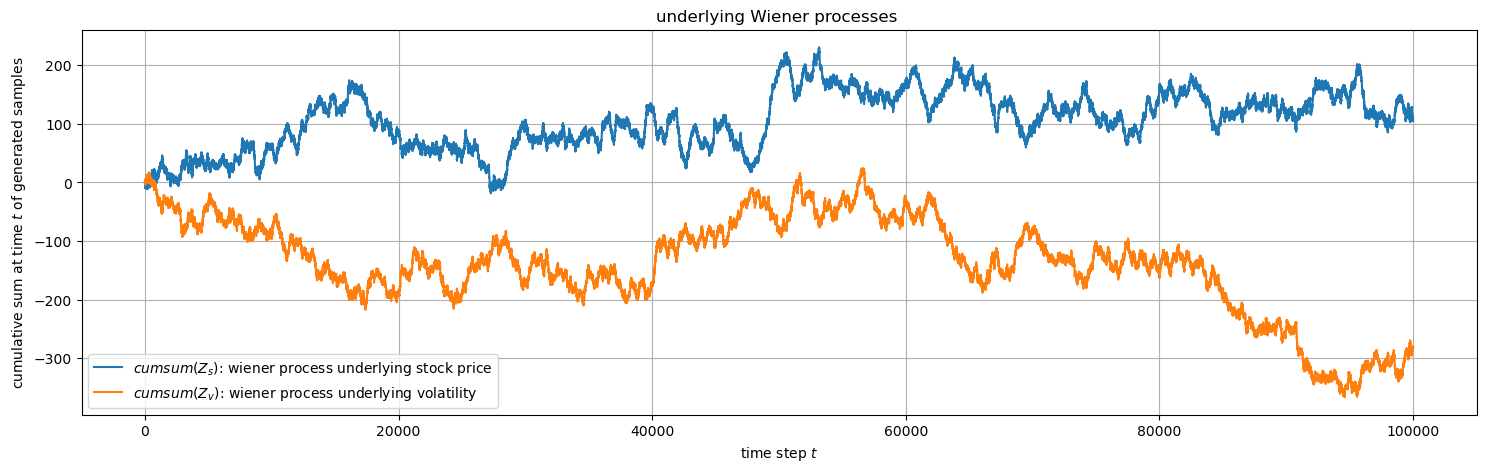


   Z_s mean: 0.0010477675636001863
   Z_s std : 0.9994226333461876
   Z_v mean: -0.002811370064434092
   Z_v std : 0.9963076294397963

   calc. correlation matrix is:
 [[ 1.         -0.60002572]
 [-0.60002572  1.        ]]
   while provided was:
 [[ 1.  -0.6]
 [-0.6  1. ]]
  Latest run timer info:

    (calc)_wiener_process_sampling_________________________:____________0.052942 sec


In [12]:
##############################
#testing correlation algorithm
##############################

rho = PAR['rho']
covariance= np.array([[1  , rho],
                      [rho, 1  ]])

reset_timers()
Z_SV=np.array(generate_sequence_corrwien())

Z_s=[z_i[0] for z_i in Z_SV.cumsum(axis=0)]
Z_v=[z_i[1] for z_i in Z_SV.cumsum(axis=0)]
plt.figure(figsize=(18,5))
plt.plot(Z_s, label="$cumsum(Z_s)$: wiener process underlying stock price")
plt.plot(Z_v, label="$cumsum(Z_v)$: wiener process underlying volatility")

plt.title('underlying Wiener processes ')
plt.ylabel('cumulative sum at time $t$ of generated samples')
plt.xlabel('time step $t$')
plt.legend()
plt.grid()
plt.show()


print()

###################
#checks correlation
###################

print("   Z_s mean:", Z_SV.T[0,:].mean())
print("   Z_s std :", Z_SV.T[0,:].std())
print("   Z_v mean:", Z_SV.T[1,:].mean())
print("   Z_v std :", Z_SV.T[1,:].std())
print()
print("   calc. correlation matrix is:\n",np.corrcoef(Z_SV.T))
print("   while provided was:\n", covariance)

dir_timers()

### 2.2.2) Heston paths

__Single path generation__

The following path is the result of **the specific wiener process generated above**

settings  :
 {'scheme': 'euler', 'n_iter': 100000}
parameters:
 {'rho': -0.6, 'r': 0.05, 'k': 2.0, 'theta': 0.1, 'sigma': 0.57, 'delta_t': 0.0001, 'S0': 100.0, 'V0': 0.1}


generating  Heston path :   0%|          | 0/100000 [00:00<?, ?it/s]

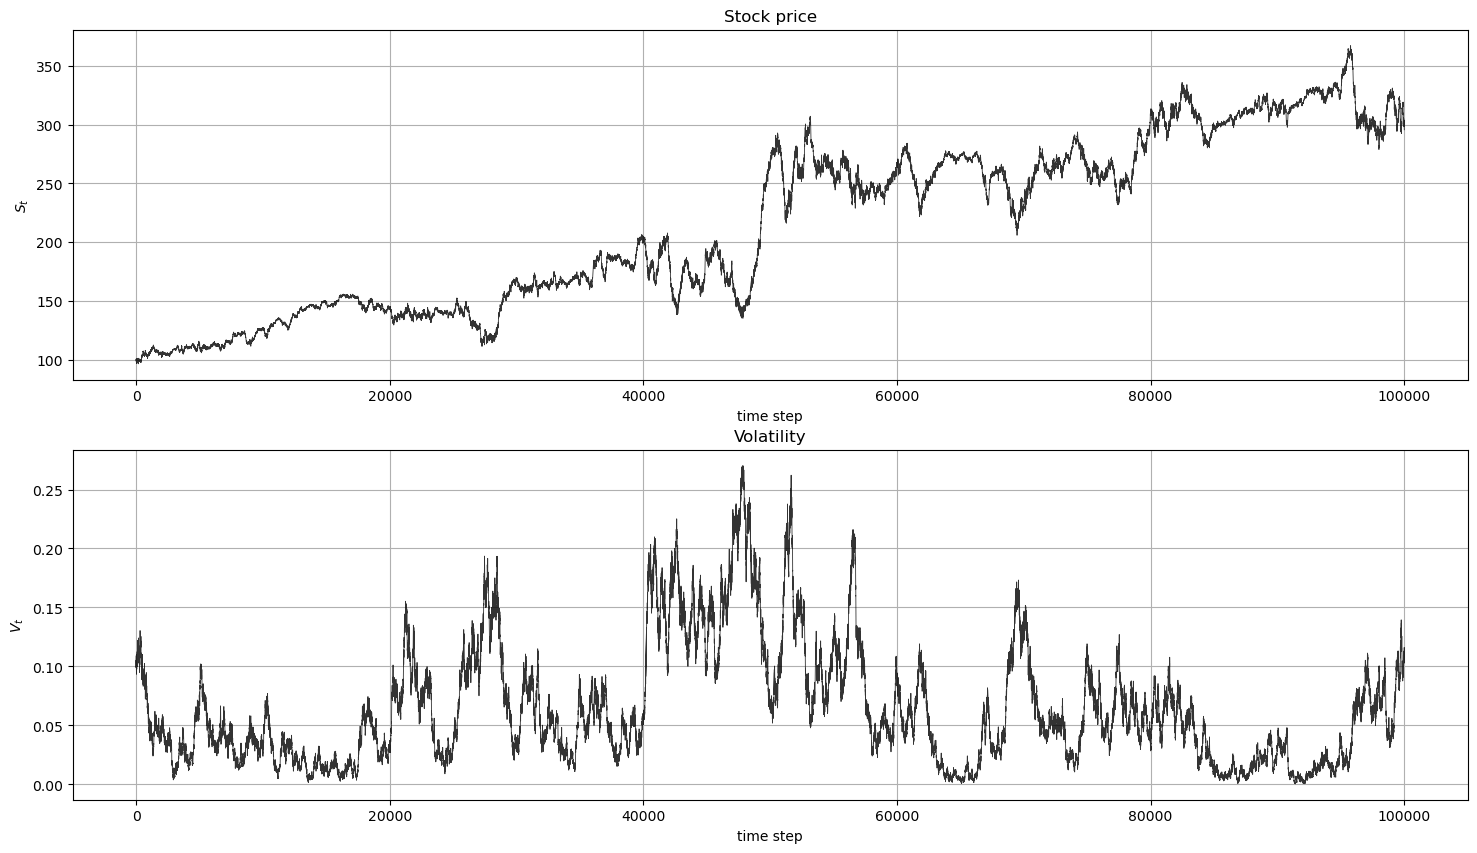

  Latest run timer info:

    (calc)_euler_scheme____________________________________:____________0.539025 sec
    (tot_)_heston_path_generation__________________________:____________1.532567 sec
    (oth_)_plotting_SV_paths_______________________________:____________0.100253 sec


In [13]:
reset_timers()
SV=generate_sequence(scheme='euler')
dir_timers()

__Multiple path generation__

Generating N_multi paths of same parametrization

running multiple instances of same paths parametrization::   0%|          | 0/5 [00:00<?, ?it/s]

generating Path 1 Heston path :   0%|          | 0/100000 [00:00<?, ?it/s]

generating Path 2 Heston path :   0%|          | 0/100000 [00:00<?, ?it/s]

generating Path 3 Heston path :   0%|          | 0/100000 [00:00<?, ?it/s]

generating Path 4 Heston path :   0%|          | 0/100000 [00:00<?, ?it/s]

generating Path 5 Heston path :   0%|          | 0/100000 [00:00<?, ?it/s]

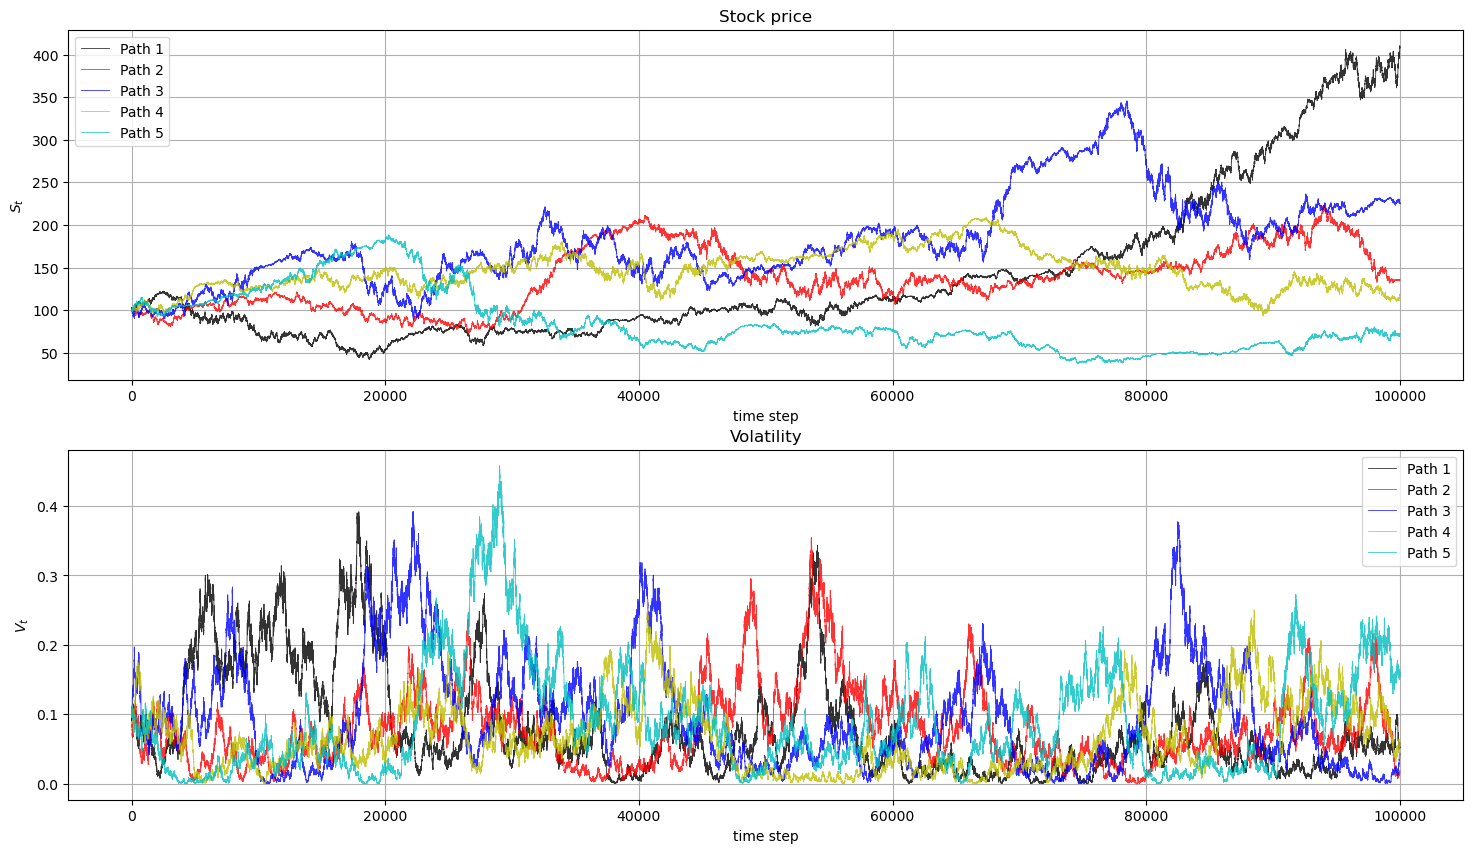

  Latest run timer info:

    (calc)_wiener_process_sampling_________________________:____________0.169320 sec
    (calc)_euler_scheme____________________________________:____________1.989457 sec
    (tech)_data_retrieving_________________________________:____________0.169320 sec
    (tot_)_heston_path_generation__________________________:____________3.293162 sec
    (tot_)_paths_generation_-_sequence_mode________________:____________4.587221 sec
    (oth_)_plotting_SV_paths_______________________________:____________0.278772 sec


In [14]:
N_multi=5

reset_timers()
generate_multi_sequence(N_multi)
dir_timers()

__Numerous paths generation__

Generate N_paths with same parametrization.

These are a more statistically significan amount of paths generated with generate_multi_sequence. This function implementation is also faster, though not optimized for visualization

  0%|          | 0/50000 [00:00<?, ?it/s]

  Latest run timer info:

    (calc)_euler_scheme____________________________________:____________0.973830 sec
    (calc)_paths_generation_-_paths_mode___________________:____________1.805963 sec

  memory usage of path tensor: 80.002 Mb


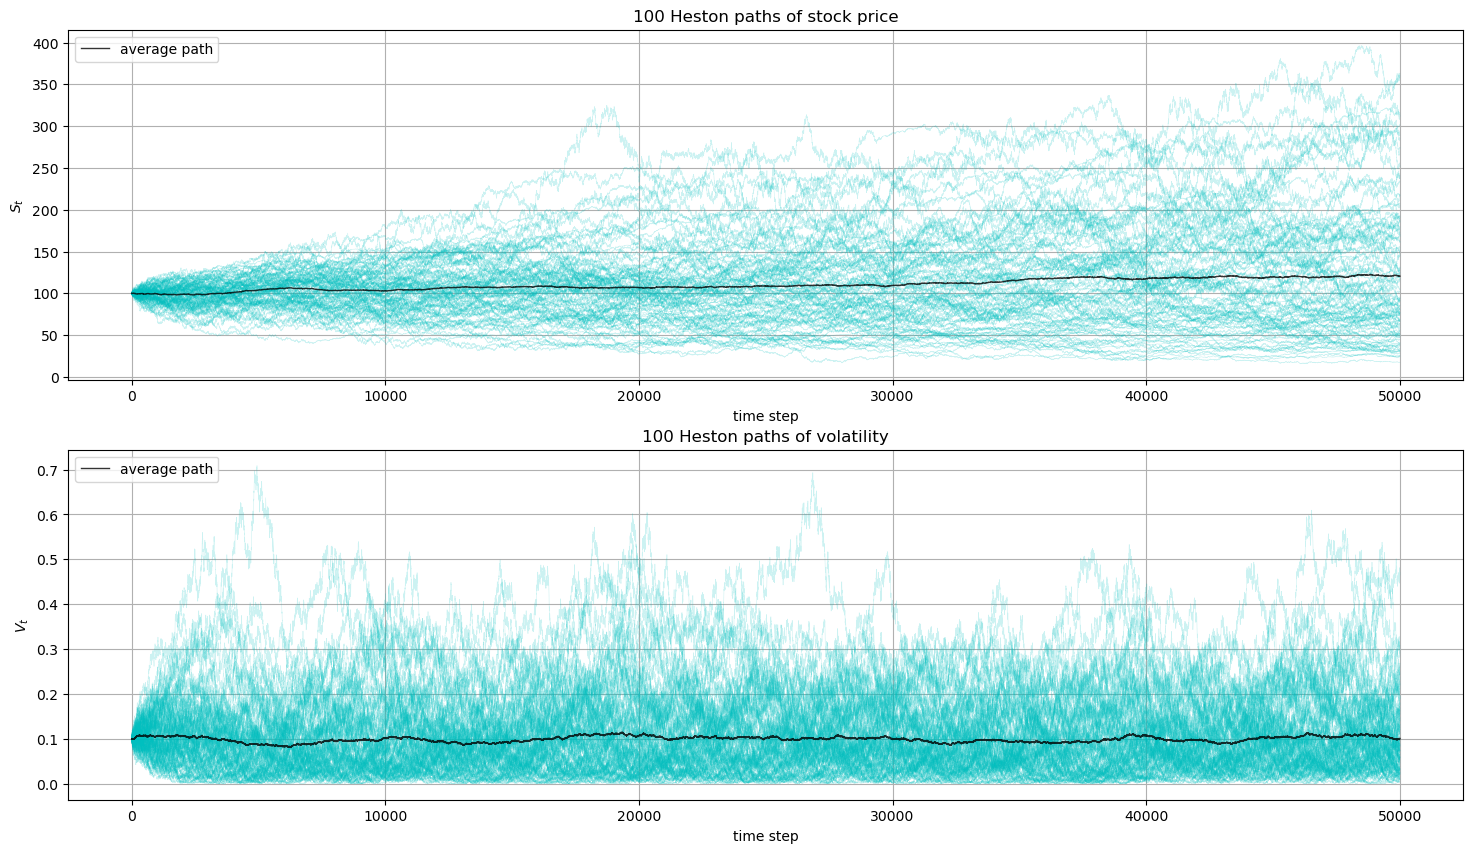

In [15]:
N_paths=100

reset_timers()
paths=generate_paths(n_paths=N_paths,n_iter=50000, scheme='euler')
dir_timers()

print(f"\n  memory usage of path tensor: {sys.getsizeof(paths)/1e6:.3f} Mb")
show_paths(paths)

# 3) Metrics

## 3.1) Function definitions

### 3.1.1) Core metric computation processes

In [16]:
#################
# METRICS
#################

def MAV(data, window=100):
    """
    takes a sequence of data (single path)
    and returns the moving average sequence on given window (100 by default)
    """
    mav=[]
    data=np.array(data)
    for i in range(len(data)):
        if i<window:
            mav.append(data[max(0,i-window+1):i+1].mean())
        else:
            mav.append(mav[-1]+(data[i]-data[i-window])/window)
    return np.array(mav)

def get_volatility(S, r='auto'):
    """
    takes a sequence of data (single path)
    and returns the associated historic volatility
    """
    spd_v=step_returns_values(S)
    if r=='auto':
        r=(spd_v.mean())/PAR['delta_t']
    v_v=(spd_v)**(2)/PAR['delta_t']
    return v_v

#---------------------------------------------- distribution of t values
def value_distr(data, n_bins=100):
    """
    build an histogram out of a sequence of data
    """
    hist_v_d =np.histogram(data,  bins=np.linspace(min(data),max(data),n_bins))  
    return hist_v_d

def get_value_distr(SV_sp, n_bins=100):
    """
    build an histogram out of a heston paths (single sequence or multiple paths of S,V)
    calls value_distr on either S or V
    can work either on multiple paths or a single sequence
    
    NB it does not compute the value pathwise (see pathwise metrics for that)
    but takes the metric value among all paths values
    """
    SV=np.array(SV_sp)
    if len(SV.shape)==2:
        S=SV2S(SV[1:])
        V=SV2V(SV[1:])
    elif len(SV.shape)==3:
        S=SV[1:,0,:].flatten()
        V=SV[1:,1,:].flatten()
    else:
        raise ValueError(f"not valid shape: {SV.shape=} ")
    v_d={}
    v_d['S']=value_distr(S, n_bins=n_bins)
    v_d['V']=value_distr(V, n_bins=n_bins)
    return v_d

#---------------------------------------------- distribution of t/t-1 step changes (returns)
def step_returns_values(data):
    """
    calculates the returns of a given data sequence (generic)
    
    returns are defined as [Value(t)-Value(t-1)]/Value(t-1)
    """
    step_prop_diff=[(data[n]-data[n-1])/data[n-1] for n in range(len(data)) if n]
    return np.array(step_prop_diff)

def step_returns_distr(data, n_bins=100, min_v='auto', max_v='auto'):
    """
    Builds an histogram out of return sequence
    """
    returns=step_returns_values(data)
    if min_v=='auto': min_v=min(returns)
    if max_v=='auto': max_v=max(returns)
    hist_returns =np.histogram(returns,  bins=np.linspace(min_v,max_v,n_bins))
    return hist_returns


def get_returns_distr(SV_sp, num_format='ratio', n_bins=1000):
    """
    builds return sequences for S and V.
    calls step_returns_distr on either S or V
    can work either on multiple paths or a single sequence
    
    NB it does not compute the value pathwise (see pathwise metrics for that)
    but takes the metric value among all paths value
    """
    SV=np.array(SV_sp)
    if len(SV.shape)==2:
        S=SV[:,0]
        V=SV[:,1]
    elif len(SV.shape)==3:
        S=SV[:,0,:]
        V=SV[:,1,:]
    else:
        raise ValueError(f"not valid shape: {SV.shape=} ")
    returns={'S':[np.array([0.]*(n_bins-1)), 'hist_x'], 'V':[np.array([0.]*(n_bins-1)), 'hist_x']}
    
    if num_format=='perc':
        Tr= lambda x: (x-1)*100  
    elif num_format=='ratio':
        Tr= lambda x: x
    else:
        raise ValueError(f"Unknown {num_format=}")
        
    if len(S.shape)==2:
        min_v, max_v= 1e10, 1e-10
        for path_data in S.T: #first scan all data to find max and min to build the histogram with
            path_values=step_returns_values(path_data)
            min_v=min(min_v, min(path_values))
            max_v=max(max_v, max(path_values))
#             print(min_v, max_v)
        for path_data in S.T:
            hist_values=step_returns_distr(path_data, #then it get step_diff value for every path
                                           min_v=min_v, max_v=max_v, n_bins=n_bins)
            returns['S'][1]=hist_values[1]
            returns['S'][0]+=np.array(hist_values[0])
            #and adds data to spd['S'] list
    else:
        returns['S']=step_returns_distr(S, n_bins=n_bins)
    if len(V.shape)==2:
        min_v, max_v= 1e10, -1e10
        for path_data in V.T: #first scan all data to find max and min to build the histogram with
            path_values=step_returns_values(path_data)
            min_v=min(min_v, min(path_values))
            max_v=max(max_v, max(path_values))
#             print(min_v, max_v)
        min_v, max_v= -0.3, +0.3 #avoids plotting of outliers
        for path_data in V.T:    
            hist_values=step_returns_distr(path_data, #then it get step_diff value for every path 
                                           min_v=min_v, max_v=max_v, n_bins=n_bins)
            returns['V'][1]=hist_values[1]
            returns['V'][0]+=np.array(hist_values[0])
            #and adds data to returns['V'] list
    else:
        returns['V']=step_returns_distr(V, n_bins=n_bins)
    return returns

### 3.1.2) Pathwise metrics

In [17]:
@timer_decorator('(mtr_)_get_r_-_sequence_mode')
def get_r(S, delta_t='def'):
    """
    takes a sequence of price (single path) 
    and returns the extimated parameter r
    """
    if delta_t=='def':
        delta_t=PAR['delta_t']
    S=np.array(S)
    returns=step_returns_values(S)
    return (returns.mean())/delta_t

@timer_decorator('(mtr_)_get_theta')
def get_theta(V):
    """
    takes a sequence of volatility (single path) 
    and returns the extimated parameter theta
    """
    V=np.array(V)
    return V.mean()

__Pathwise metric for the whole generated path tensor__

In [18]:
@timer_decorator('(mtr_)_paths2metric')
def paths2metric(paths, SorV, metric_fn, progressbar_fn=lambda x:x):
    """
    Computes metric_fn on every provided path
    paths must be a tensor of 3 shapes: [n_iter, SorV, n_paths]
    SorV must be character "S" (for metric on stock prices) or "V" (for metric on volatility)
    metric_fn must be a function that takes a sequence and returns a value
    progressbar is none by default; A function to apply to iterator can be provided ny progressbar_fn
    
    The function returns a list of metric values for each path
    """
    #------------------ checkings parameters are acceptable
    assert len(paths.shape)==3 #check if it is a path tensor
    n_paths=paths.shape[-1]
    if   SorV.lower()=='s':idx=0
    elif SorV.lower()=='v':idx=1
    else: raise ValueError(f"SorV must be 'S' or 'V'. Provided {SorV}")
    
    #------------------ calc. and returns metric values
    return [metric_fn(paths[:,idx,i]) for i in progressbar_fn(range(n_paths))]

@timer_decorator('(mtr_)_get_r_-_paths_mode')
def get_r_pathwise(paths, delta_t='def'):
    """
    takes the whole path info (multiple path in a path tensor [time:SorV:path])
    and returns r computed pathwise (so an array of extimated r values)
      
    does the same of paths2metric( ...,metric_fn=get_r)
    but does it faster, since that metric might run very slowly for big N_paths
    """
    if delta_t=='def':
        delta_t=PAR['delta_t']
    S_paths=paths[:,0,:]
    returns=step_returns_values(S_paths)
    return (returns.mean(axis=0))/delta_t

@timer_decorator('(mtr_)_paths2metric_CV')
def paths2metric_CV(paths, SorV, metric_fn, progressbar_fn=lambda x:x):
    """
    uses paths2metric to compute metric_fn value over given paths[SorV]
    then returns the coefficient of variation for that distribution, the average and standard deviation
        NB coefficient of variation is standard_deviation/average   
    """
    metric_values=np.array(paths2metric(paths, SorV, metric_fn, progressbar_fn=progressbar_fn))
    avg=metric_values.mean()
    std=metric_values.std()
    return std/avg, avg, std

@timer_decorator('(mtr_)_paths2metric_CV_r')
def paths2metric_CV_r(paths):
    """
    specific instance of paths2metric_CV for extimated r values  
    since its evaluation can take time
    """
    metric_values=get_r_pathwise(paths)
    avg=metric_values.mean()
    std=metric_values.std()
    return std/avg, avg, std

### 3.1.3) Scheme comparison

In [19]:
@timer_decorator('(tot_)_run_scheme_comparison - sequence mode')
def compare_scheme_sequence(schemes=_implemented_schemes, Z_sv='fetch_or_new', verbosity=2, **par_and_settings):
    """
    NB for a statistically significant comparison test use compare_scheme_paths
        since this function is slow ad optimized for visualization, 
        while compare_scheme_paths is optimized for speed
    
    this function runs different schemes (schemes) on the same underlying wiener process (Z_vs)
    it returns a matrix with differences data
    if Z_sv argument is not provided, it will try to fetch a global Z_SV variable else builds a new one 
        if Z_sv='new' it will create a new instance of wiener process
        if Z_sv='fetch' it will force the fetching of the Z_SV variable (raises error if not found)
    schemes argument must be an iterable of strings (name of the scheme)
        look at _implemented_schemes to see available one in the system
    par_and_settings kwargs work the same as generate_sequence 
        only difference is that plot kwargs are managed locally
        so they raise error if passed to this function
    """
    ################################# parameters retrieving
    par, sett=_retrieve_parameters(**par_and_settings)
    Z_sv=_retrieve_wiener(Z_sv, par, sett)
    
    ################################# building paths, plotting path (if requested)
    if verbosity>=2:
        plt.figure(figsize=(18,10))
    results={}
    for col,scheme_name in zip(['c','y','g','m','r','b'], schemes):
        results[scheme_name]=generate_sequence(scheme=scheme_name, Z_sv=Z_sv, #<--- all evaluated on same wiener
                                            sequence_name=scheme_name, color=col, alpha=0.6, verbosity=verbosity,
                                            **par_and_settings
                                            )
    if verbosity>=2:
        plt.show()
        
    ################################# building differences matrix, plotting it (if requested)
    grid_diff=np.zeros((2, len(schemes), len(schemes), sett['n_iter']))
    for i,(scheme_name_1, scheme_path_1) in enumerate(results.items()):
        for j,(scheme_name_2, scheme_path_2) in enumerate(results.items()):
            diff=np.array(scheme_path_1[1:])-np.array(scheme_path_2[1:]) #[1:] because first element is not generated
            grid_diff[:,i,j,:]=diff.T
#             print(scheme_name_1, 'vs', scheme_name_2,':', diff)  
    if verbosity>=2:
        plt.figure(figsize=(13,4))
        plot_grid_diff(schemes, grid_diff.mean(axis=-1))
        plt.show()
        
    return grid_diff


In [20]:
@timer_decorator('(tot_)_run_scheme_comparison - paths mode')
def compare_scheme_paths(n_paths, schemes=_implemented_schemes, **par_and_settings):
    """
    Routine for testing different schemes
    
    this function runs different schemes (schemes) on the same underlying wiener process (Z_vs)
        it returns a matrix with differences data

    schemes argument must be an iterable of strings (name of the scheme)
        look at _implemented_schemes to see available one in the system
    par_and_settings kwargs work the same as generate_sequence 
        only difference is that plot kwargs are managed locally
        so they raise error if passed to this function
    """
    
    verb_fn= lambda x, scheme_name: tqdm(x, desc="generating paths for scheme "+scheme_name)
    par, sett=_retrieve_parameters(**par_and_settings) 
    Z_12 = np.random.normal(0,1,size=int(n_paths*sett['n_iter']*2)).reshape(2, int(sett['n_iter']), int(n_paths))
    Z_v=Z_12[0,:,:]
    Z_s=rho*Z_v+(1-rho**2)**(1/2)*Z_12[1,:,:]
    Z_sv=np.array(list(zip(Z_s, Z_v)))
    
    paths={}
    for scheme_name in tqdm(schemes, desc=" for schemes "+', '.join(schemes)):
        sett['scheme']=scheme_name
        next_iter=_retrieve_scheme(par, sett)
        
        S0, V0= np.array([par['S0']]*int(n_paths)), np.array([par['V0']]*int(n_paths))
        X=[[S0,V0]]
        for t in verb_fn(range(int(sett['n_iter'])), scheme_name):
            X.append(next_iter(X[t], Z_sv[t]))
        paths[scheme_name]=np.array(X)
    
#     print(np.array(list(paths.values()))[-5:,:,0])
    ################################# building differences matrix, plotting it (if requested)
    grid_diff=np.zeros((2, len(schemes), len(schemes), int(sett['n_iter']*n_paths)))
    for i,(scheme_name_1, scheme_paths_1) in enumerate(paths.items()):
        for j,(scheme_name_2, scheme_paths_2) in enumerate(paths.items()):
            diff=scheme_paths_1[1:]-scheme_paths_2[1:] #[1:] because first element is not generated
            # diff is shaped [time:SV:path]
            grid_diff[0,i,j,:]=diff[:,0,:].flatten()
            grid_diff[1,i,j,:]=diff[:,1,:].flatten()

    assert grid_diff.shape== (2, len(schemes), len(schemes), int(sett['n_iter']*n_paths))
    plt.figure(figsize=(13,4))
    plot_grid_diff(schemes, grid_diff.mean(axis=-1))
    plt.show()

    n_schemes=len(schemes)
    for g_d_v, attr_name in zip(grid_diff, ['stock prices', 'volatility']):
        plot_count=0
        plt.figure(figsize=(18,5))
        for i, (data_array, scheme_name_i) in enumerate(zip(g_d_v, _implemented_schemes)):
            for j, (data, scheme_name_j) in enumerate(zip(data_array, _implemented_schemes)):
                if i>=j: continue
                plot_count+=1
                scheme_idx=plot_count     #<--- line plot
#                 scheme_idx=i*n_schemes+j+1 <--- squared grid plot
                plt.subplot(1,n_schemes,scheme_idx)
                plt.title(attr_name+" differences: "+scheme_name_i+" - "+scheme_name_j)
                plt.hist(data, 1000, color='k')
                average=data.mean()
                plt.axvline(average, c='r', ls='--', alpha=0.7, label=f'{average=}')
                plt.grid(visible=True,alpha=0.6)
                plt.legend()
                plt.ylabel("Occurrences")
                plt.xlabel("differences of returns")
        plt.show()
        
    return grid_diff.mean(axis=-1)

### 3.1.4) Metrics visualization

Each of these functions, either display the requested metric or return the metric values

__Visualization of sequence metrics__

In [21]:
###############################################
# showing metrics value and return their output

@timer_decorator('(oth_)_getshow_mav')
def getshow_mav(SV, mav_values=[100,1000,10000]):  
    """
    show mav and returns it
    
    the mav will be computed in mav_values
        that must be provided as an iterable of int
    """
    plt.figure(figsize=(18,10))
    plot_SV(SV, linewidth=0.4, alpha=0.4, label='path')
    S=SV2S(SV)
    V=SV2V(SV)
    mav={}
    for mav_v, color in zip(tqdm(mav_values, desc='calculating mav'), ['y','c','m','r']):
        mav[mav_v]={}
        plt.subplot(2,1,1)
        mav[mav_v]['S']=MAV(S, window=mav_v)
        plt.plot(mav[mav_v]['S'], label='mav '+str(mav_v))
        plt.subplot(2,1,2)
        mav[mav_v]['V']=MAV(V, window=mav_v)
        plt.plot(mav[mav_v]['V'], label='mav '+str(mav_v))
        
    plt.subplot(2,1,1)
    plt.legend()
    plt.grid(visible=True, alpha=0.7)
    plt.subplot(2,1,2)
    plt.legend()
    plt.grid(visible=True, alpha=0.7)
    plt.show()
    return mav

@timer_decorator('(oth_)_getshow_value_distr')
def getshow_value_distr(SV_sp,n_bins=1000):
    """
    show value distribution and returns it
    
    n_bins is the histogram granularity
    """
    v_d=get_value_distr(SV_sp,n_bins=n_bins)
    SV=np.array(SV_sp)
    if len(SV.shape)==2:
        S0=SV[0,0]
        V0=SV[0,1]
        S= SV[1:,0]
        V= SV[1:,1]
    elif len(SV.shape)==3:
        S0=SV[0,0,0]
        V0=SV[0,1,0]
        S= SV[1:,0,:].flatten()
        V= SV[1:,1,:].flatten()
    
    plt.figure(figsize=(18,10))    
    plt.subplot(1,2,1)
    plt.title("distribution of $S_{t}$ ")
    
    plt.plot(v_d['S'][1][1:],v_d['S'][0])
    avg=np.array(S).mean()
    plt.axvline(avg, c='r', ls='--', label='average value: '+str(avg)[:10])
    plt.axvline(S0,  c='k', ls='--', label='initial_value: '+str(S0)[:10])
    plt.ylabel('frequency')
    plt.xlabel(f'values ({n_bins=})')
    plt.xlabel(f"$S_t$ ({n_bins=})")
    plt.grid()
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title("distribution of $V_{t}$ ")
    
    plt.plot(v_d['V'][1][1:],v_d['V'][0])
    avg=np.array(V).mean()
    plt.axvline(avg, c='r', ls='--', label='average value: '+str(avg)[:10])
    plt.axvline(V0,  c='k', ls='--', label='initial_value: '+str(V0)[:10])
    plt.ylabel('frequency')
    plt.xlabel(f'values ({n_bins=})')
    plt.xlabel(f"$V_t$ ({n_bins=})")
    plt.grid()
    plt.legend()
    
    plt.show()
    return v_d

@timer_decorator('(oth_)_getshow_returns_distr')
def getshow_returns_distr(SV_sp, num_format='ratio',n_bins=1000):
    """
    show returns distribution and return it
    
    num_format="ratio": the raw ratio is shown
    num_format="perc" : the data are shown applying (x-1)*100 transformation
    returned values are always, a dictionary of step_returns_distr
      with keys 'S','V' and 2 list:[0] for the values, [1] for the frequency
    """        

    returns=get_returns_distr(SV_sp, num_format=num_format, n_bins=n_bins)
    SV=np.array(SV_sp)
    if len(SV.shape)==2:
        S=SV[:,0]
        V=SV[:,1]
    elif len(SV.shape)==3:
        S=SV[:,0,:]
        V=SV[:,1,:]
        
    if num_format=='perc':
        Tr= lambda x: x*100  
    elif num_format=='ratio':
        Tr= lambda x: x
    else:
        raise ValueError(f"Unknown {num_format=}")
    
    plt.figure(figsize=(18,10))
    plt.subplot(1,2,1)
    plt.title("Returns of $S_t$ distribution (format: "+num_format+")")
    plt.plot(Tr(returns['S'][1][1:]),returns['S'][0])
    avg=Tr(np.array(step_returns_values(S)).mean())
    plt.axvline(avg, c='r', ls='--', label=f'average value: {avg:15f}')
    plt.ylabel('frequency')
    plt.xlabel(f'returns ({n_bins=})')
    plt.grid()
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title("Returns of $V_t$ distribution (format: "+num_format+")")
    
    plt.plot(Tr(returns['V'][1][1:]),returns['V'][0])
    avg=Tr(np.array(step_returns_values(V)).mean())
    plt.axvline(avg, c='r', ls='--', label=f'average value: {avg:15f}')
    plt.ylabel('frequency')
    plt.xlabel(f'returns ({n_bins=})')
    plt.grid()
    plt.legend()
    
    plt.show()
    return returns

__Visualization of pathwise distribution__

Plotting a variable distribution, providing info about its average, standard deviation (symmetric and asymmetric) and visually comparing with some expected value

In [22]:
def plot_distr(values, plot_avg=True, plot_std=True, n_bins=100, title=None, var_name='X', var_true=None):
    """
    Plots distribution of provided values as an istogram of n_bins
    Returns average and standard deviation of the values
    
    This function does not show the plot inline but adds it to pyplot buffer 
         call pyplot.show() to display it, or can use it as part of a more articulated plot
    If requested it plots average and standard deviation
        if so, standard deviation is displayed in 3 ways: 
            std of all values, std for values < average and std for values > average
    If provided, it plots a "true value" for that variable (var_true)
    Can provide title and variable name
        If provided, var_name will be always used inside a f"...$...{var_name}...$..." format specifier
    """
    values=np.array(values)
    avg=values.mean()
    std=values.std()
    
    #----------------------- probability density histogram
    min_v=min(values)
    max_v=max(values)
    bins=np.linspace(min_v,max_v,n_bins)
    size_bins=bins[1]-bins[0]
    hist_values=np.histogram(values,  bins=bins)
    h_v=[0,1]
    h_v[0]=hist_values[1][1:]-size_bins/2
    h_v[1]=hist_values[0]/(hist_values[0].sum())
#     print(h_v[1])
    plt.plot(h_v[0], h_v[1],
            color='k', linewidth=.8, label='Probability density', alpha=0.7)
    
    #----------------------- true value (if provided)
    if var_true is not None:
        plt.axvline(var_true, 
                    c='r', ls='--', linewidth=.8, 
                    label=f"$\hat{var_name}={var_true:.4f}$")
        
    #----------------------- distribution average (if requested)
    if plot_avg:
        plt.axvline(avg, 
                    c='k', ls='--', linewidth=0.8,
                    label=f"$avg({var_name})=$ {avg:.4f}\n$std({var_name})=$ {std:.4f}")
    
    #----------------------- distribution st. dev (if requested)
    if plot_std:
        lh_std=np.array([(v-avg)**2 for v in values if v < avg]).mean()**(1/2)
        rh_std=np.array([(v-avg)**2 for v in values if v > avg]).mean()**(1/2)        
        asymmetric_std = np.array([lh_std, rh_std]*2).reshape(2,2)
    #     print(asymmetric_std)
    #     print(avg)
    #     print(std)
        plt.errorbar([avg]*2, [max(h_v[1])/3*2]*2, xuplims=[True, False], xlolims=[False, True], 
                     fmt='k-|',linewidth=.6, xerr=asymmetric_std, 
                     label=f"$std({var_name}<avg({var_name}))=${lh_std:.4f};\n$std({var_name}>avg({var_name}))=${rh_std:.4f}")
        
    #----------------------- plot visualization    
    if title is not None:
        plt.title(title)
    else:
        plt.title(var_name+' distribution')
        
    plt.xlabel(f"Values of ${var_name}$ (in {n_bins} bins)")
    plt.ylabel(f"Bin density")
    plt.grid(visible=True, alpha=0.7)
    plt.legend(loc='best')
    
    return avg, std

__Visualization for scheme comparison__

In [23]:
@timer_decorator('(oth_)_plotting_grid_diff')
def plot_grid_diff(schemes, grid_diff):
    """
    Built-in module for scheme comparison routines
    """
    plt.subplot(1,2,1)
    plt.title("Average difference of stock prices")
    plt.imshow(grid_diff[0], cmap='bwr')
#         locs, labels = plt.xticks()
    plt.xticks(np.arange(len(schemes)), schemes, rotation=30)
    plt.yticks(np.arange(len(schemes)), schemes, rotation=30)
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.title("Average difference of volatility")
    plt.imshow(grid_diff[1], cmap='bwr')
#         locs, labels = plt.xticks()
    plt.xticks(np.arange(len(schemes)), schemes, rotation=30)
    plt.yticks(np.arange(len(schemes)), schemes, rotation=30)
    plt.colorbar()

## 3.2) Application

Displaying MAVs of the first path generated in 2.2.2

calculating mav:   0%|          | 0/3 [00:00<?, ?it/s]

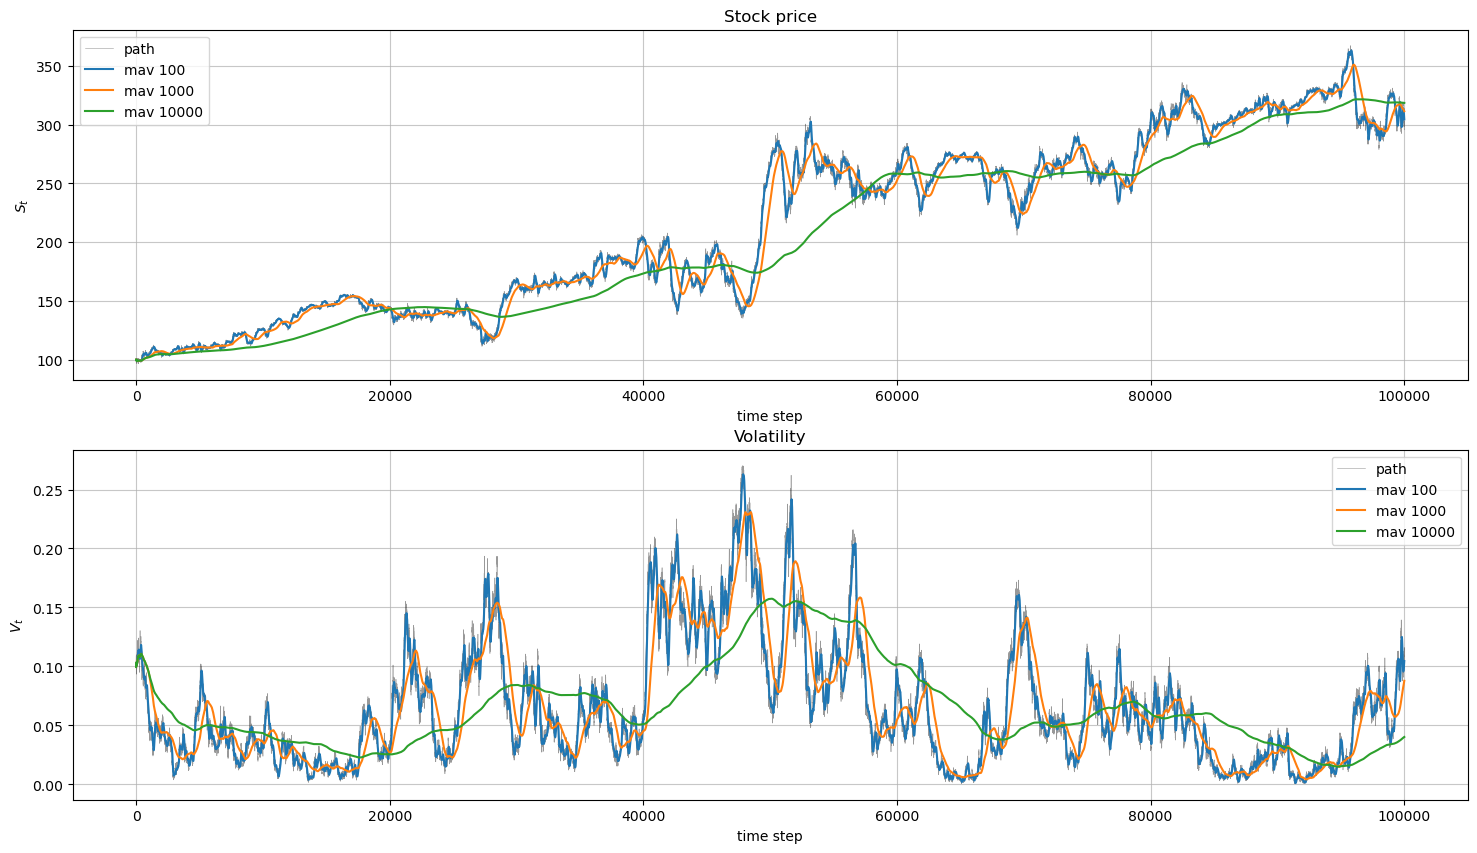

In [24]:
mavs=[100,1000,10000]

getshow_mav(SV, mav_values=mavs)
print()

Comparison of historic volatility against model volatility for first path generated in 2.2.2

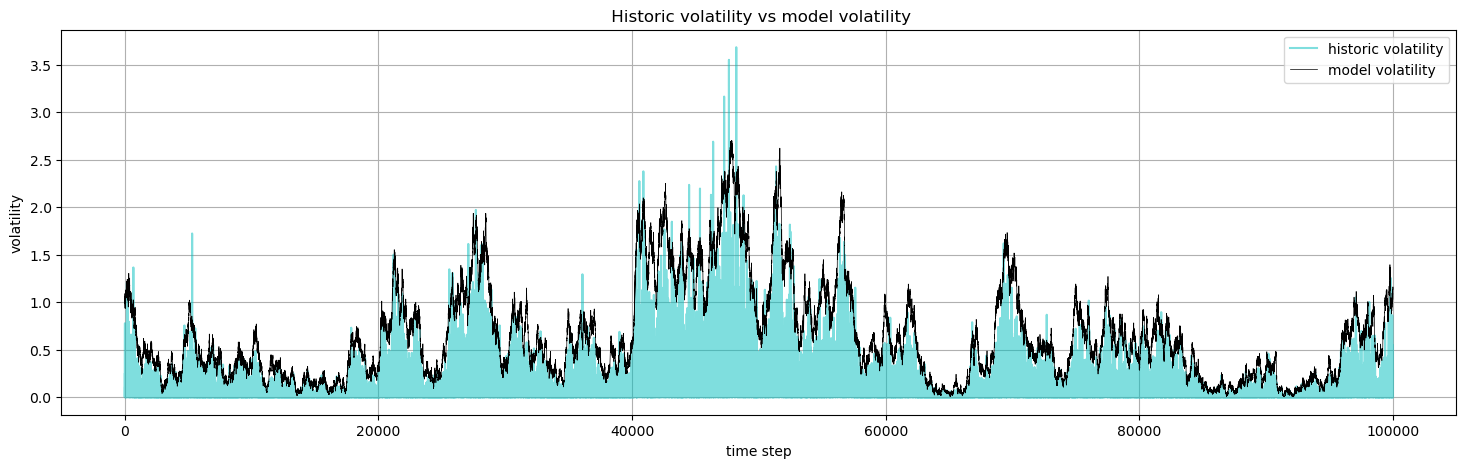

In [25]:
plt.figure(figsize=(18,5))
emp_volatility=get_volatility(SV2S(SV), r=PAR['r'])
plt.plot(emp_volatility, color='c', alpha=0.5, label='historic volatility')
plt.plot(np.array(SV2V(SV))*10, linewidth=0.5, c='k', label='model volatility')
plt.title(" Historic volatility vs model volatility")
plt.legend()
plt.grid()
plt.ylabel("volatility")
plt.xlabel("time step")
plt.show()

Path values: distribution over all paths generated in 2.2.2

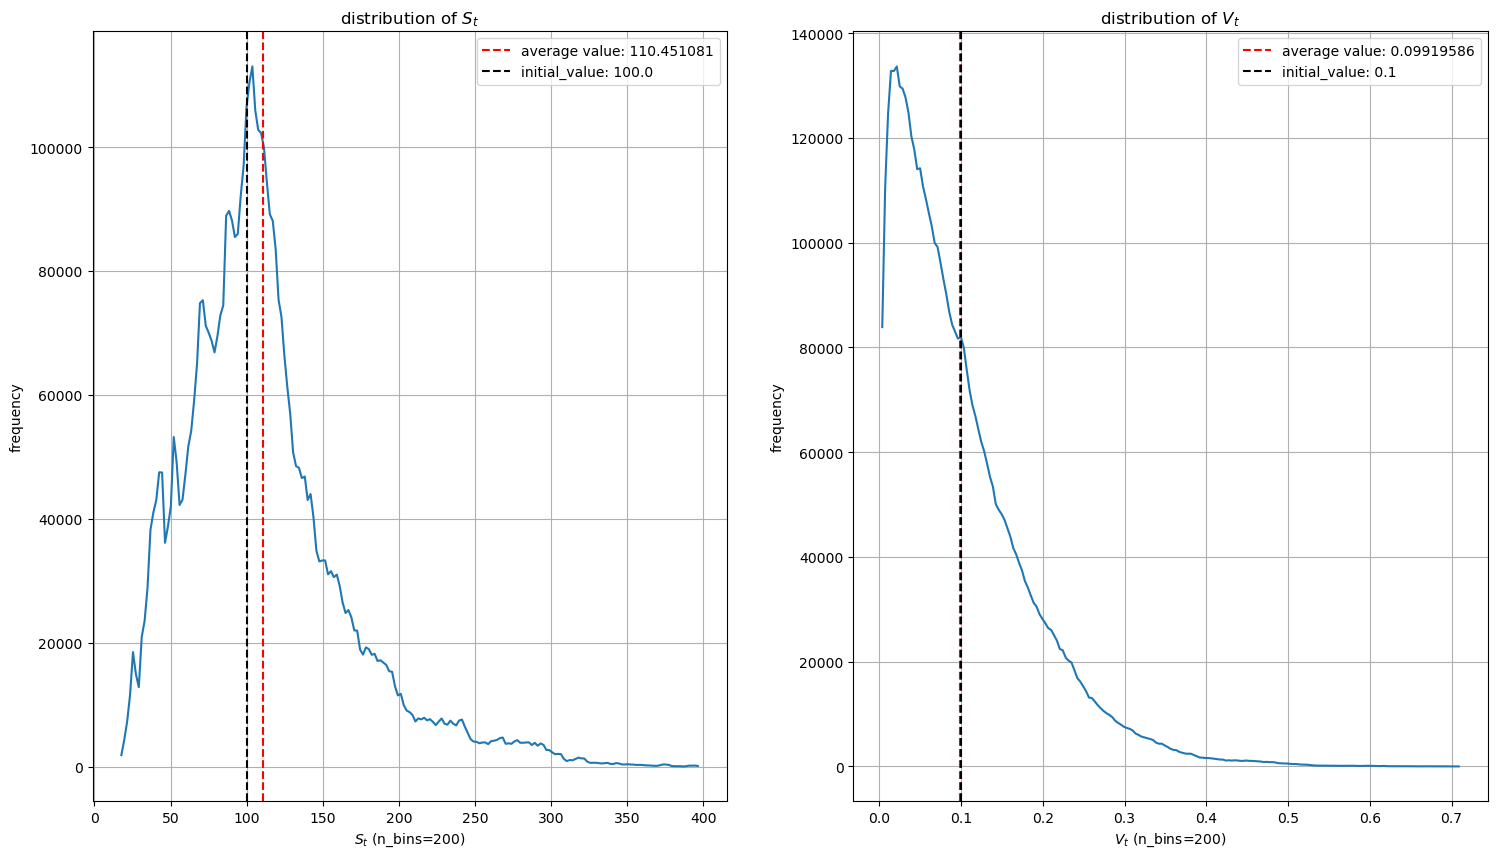

In [26]:
getshow_value_distr(paths, n_bins=200)
print()

Ratio of a paths value at time $t$ over their value at previous time $t-1$: distribution over all paths generated in 2.2.2

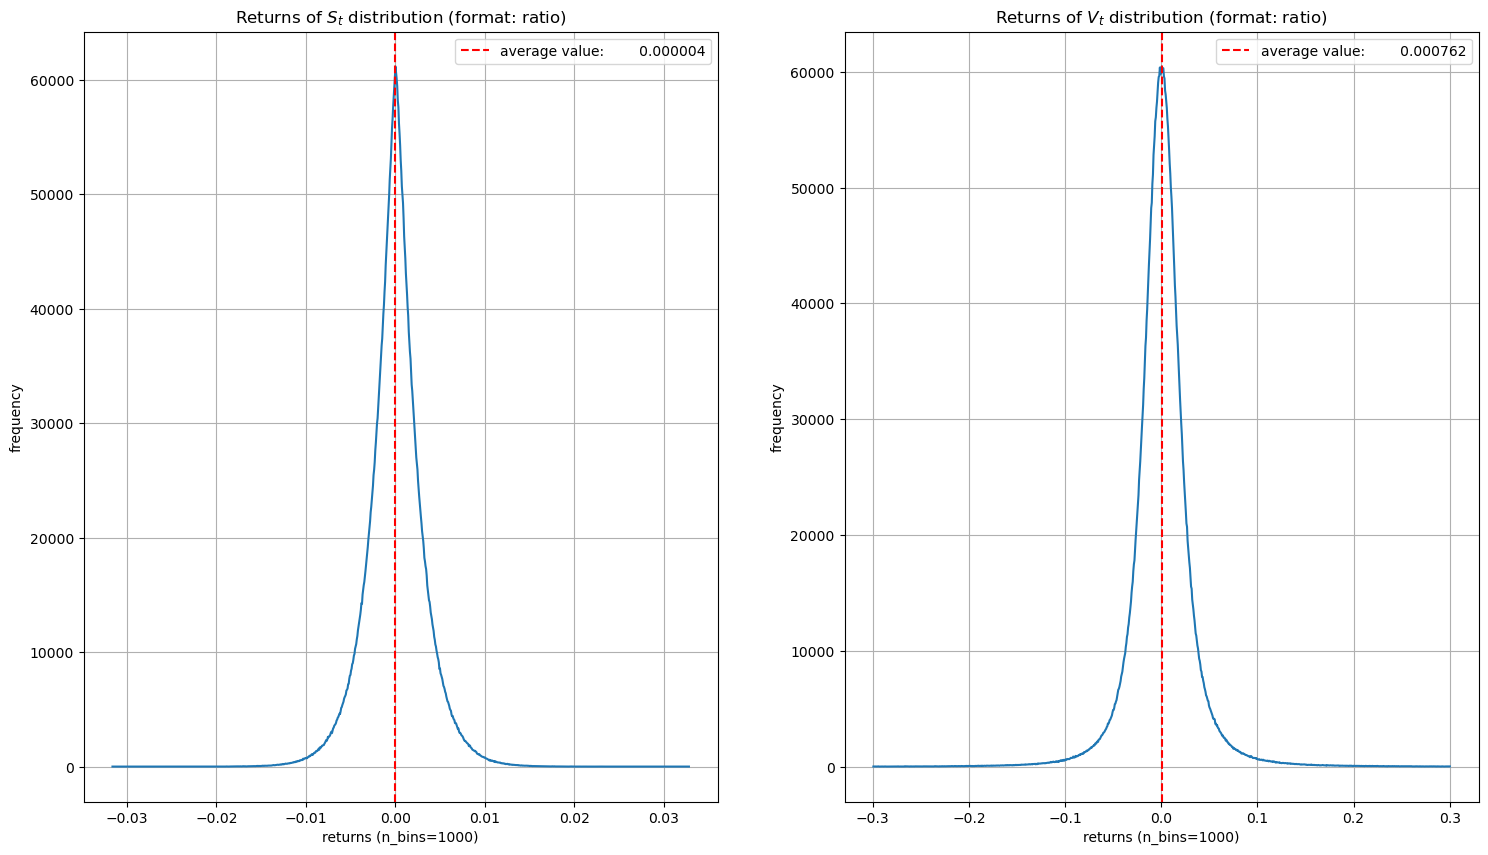

In [27]:
getshow_returns_distr(paths)#, num_format='perc')
print()

Visualizing scheme comparison for first sequence generated in 2.2.2

generating euler Heston path :   0%|          | 0/100000 [00:00<?, ?it/s]

generating logeuler Heston path :   0%|          | 0/100000 [00:00<?, ?it/s]

generating milstein Heston path :   0%|          | 0/100000 [00:00<?, ?it/s]

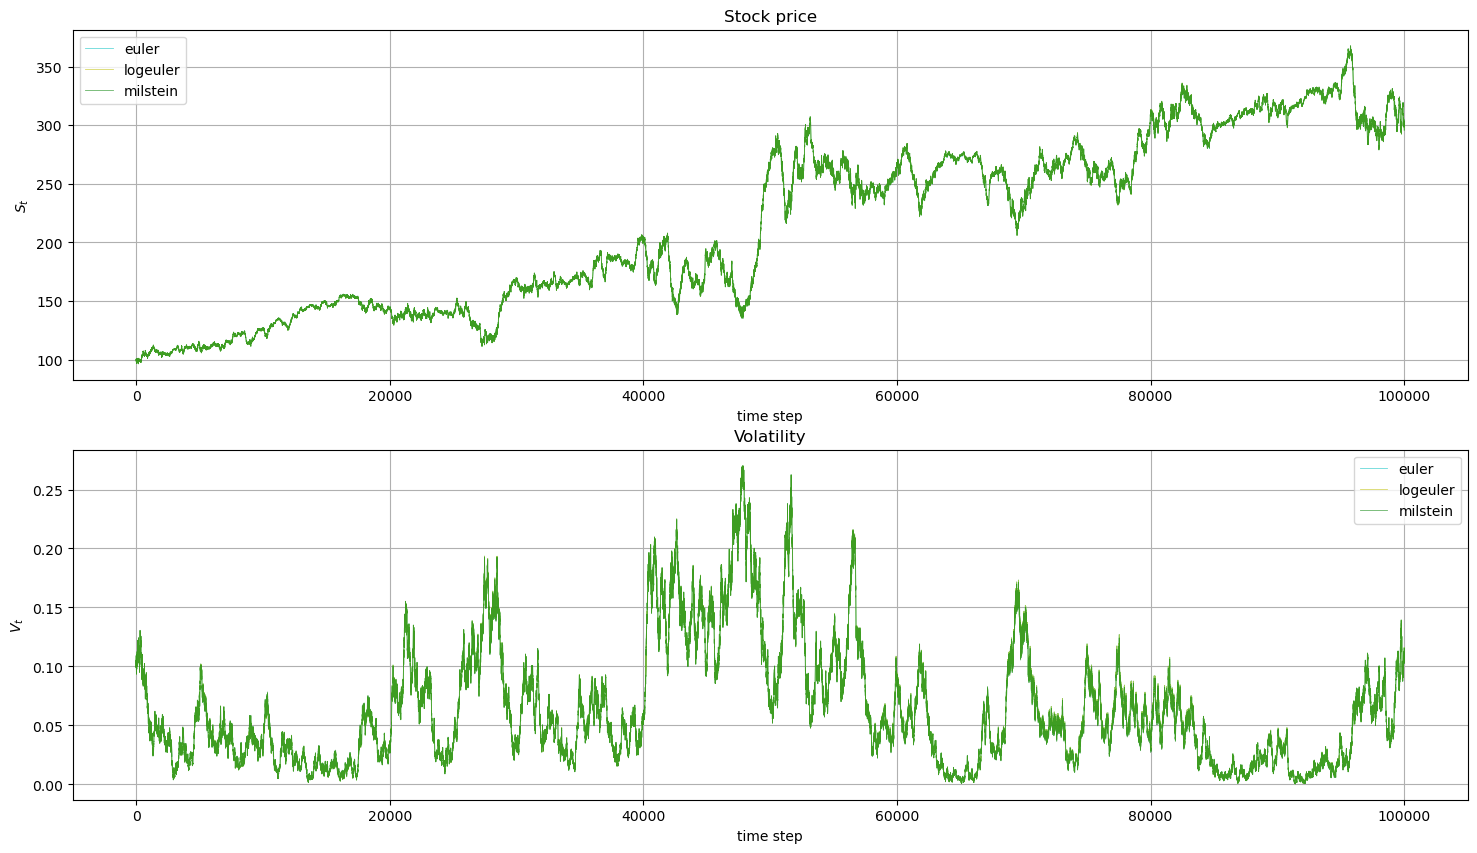

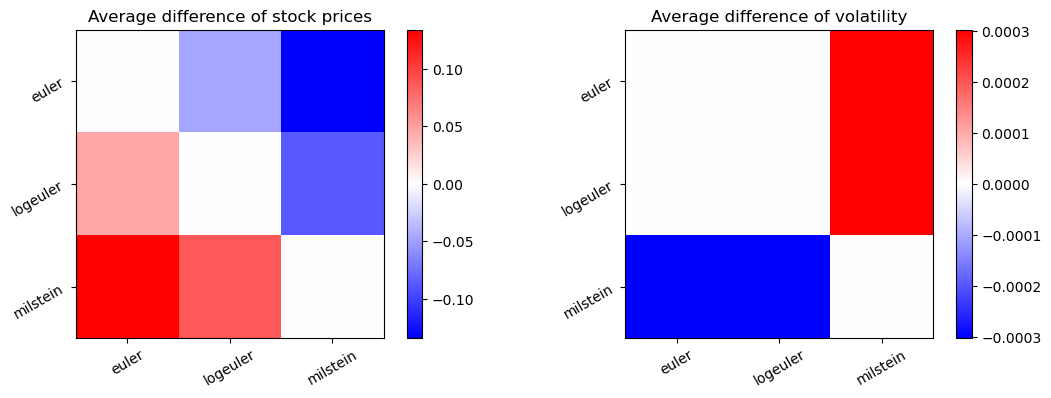

In [28]:
compare_scheme_sequence(Z_sv='fetch')
print()

Testing scheme comparison for all implemented schemes

 for schemes euler, logeuler, milstein:   0%|          | 0/3 [00:00<?, ?it/s]

generating paths for scheme euler:   0%|          | 0/5000 [00:00<?, ?it/s]

generating paths for scheme logeuler:   0%|          | 0/5000 [00:00<?, ?it/s]

generating paths for scheme milstein:   0%|          | 0/5000 [00:00<?, ?it/s]

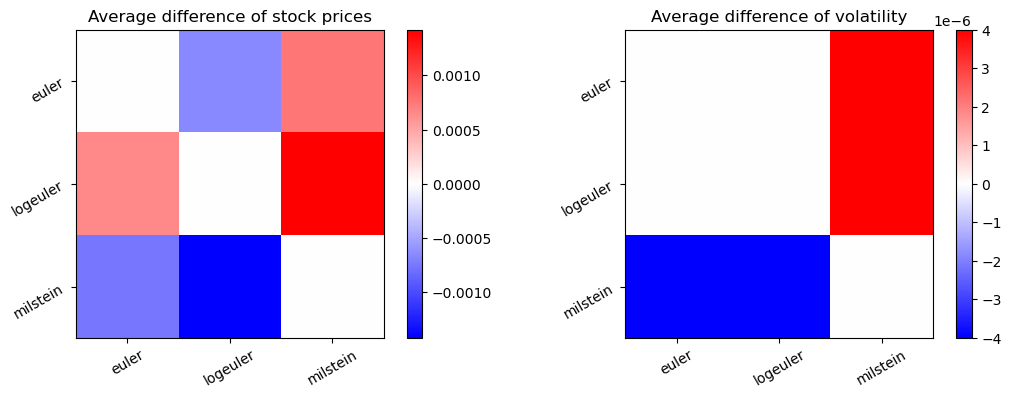

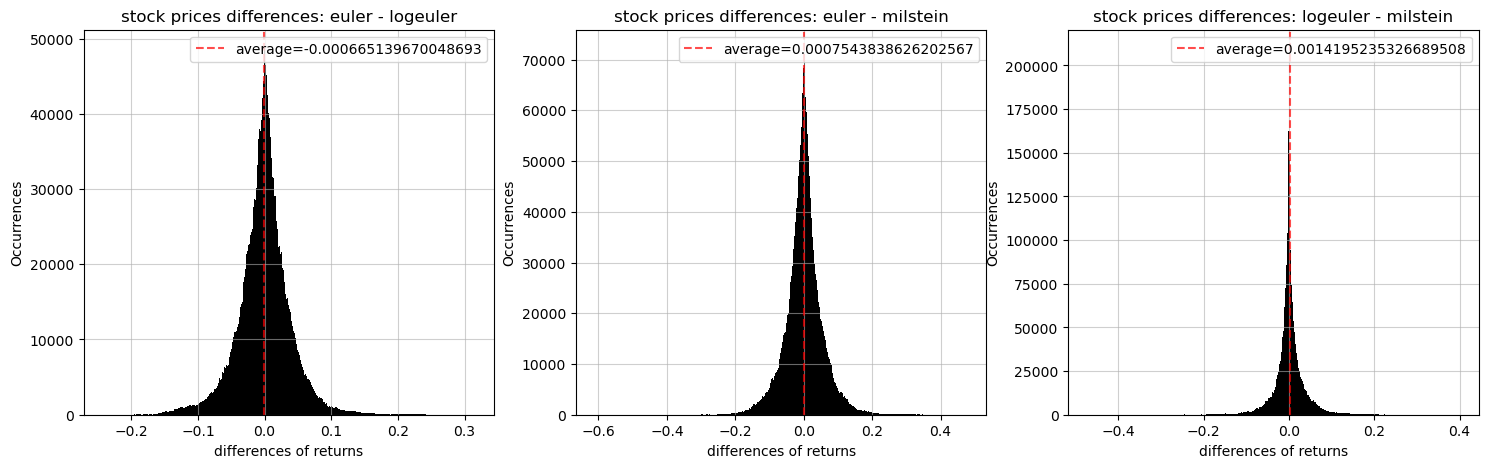

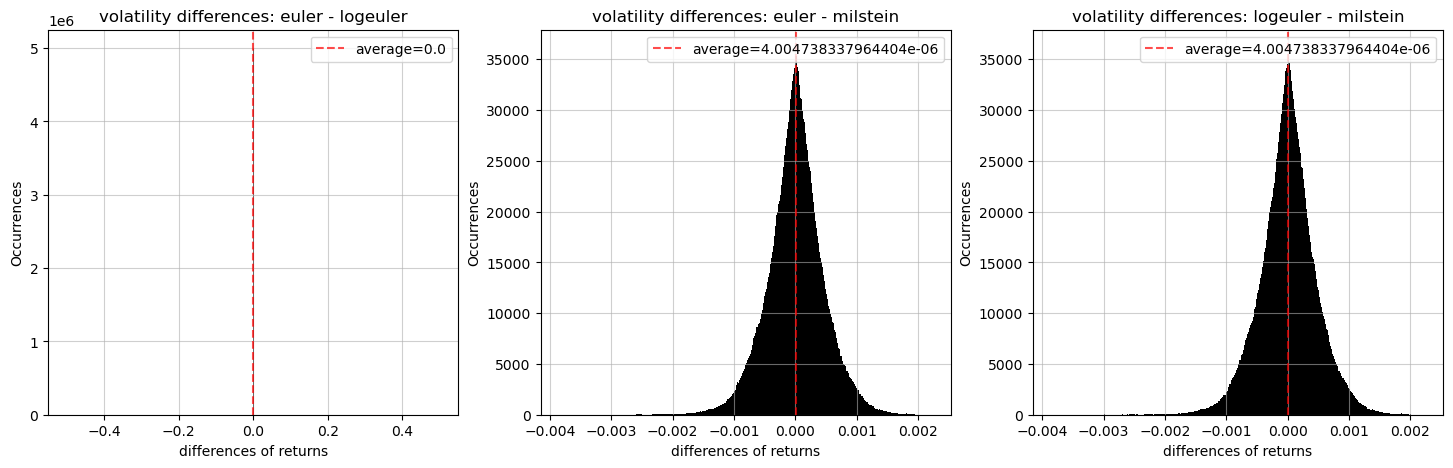

  Latest run timer info:

    (calc)_euler_scheme____________________________________:____________0.222624 sec
    (calc)_logeuler_scheme_________________________________:____________0.269567 sec
    (calc)_milstein_scheme_________________________________:____________0.416794 sec
    (tot_)_run_scheme_comparison - paths mode______________:___________35.556211 sec
    (oth_)_plotting_grid_diff______________________________:____________6.095702 sec


In [29]:
reset_timers()
SETTING['n_iter']=5000
compare_scheme_paths(1000)
dir_timers()

Distribution of pathwise metrics for default parametrization

In [30]:
#----------------------------------- setting parametrization
N_PATHS=5000
N_ITER =2000

TRUE_R=PAR['r']
TRUE_THETA=PAR['theta']
#---- uses same parameters used above

SETTING['n_iter']=N_ITER
# SETTING['n_paths']=N_PATHS
#---- changes default setting of n_iter
     #(so that every path will be generated with this lenght without having to ask for it)
    
extimated_memory=N_PATHS*N_ITER*2*8 #<--- (8 bytes for a numpy.float64)
extimated_memory/=1024**2
print(f"  extimated memory usage: {extimated_memory:.3f} Mb")    

  extimated memory usage: 152.588 Mb


In [31]:
#----------------------------------- generating paths
reset_timers()
PATHS=generate_paths(N_PATHS)#, n_iter=N_ITER, r=TRUE_R, theta=TRUE_THETA)
print(f"path tensor memory usage: { sys.getsizeof(PATHS)/1024**2:.3f} Mb")
# the memory difference from extimated memory usage should be numpy array metadata

  0%|          | 0/2000 [00:00<?, ?it/s]

path tensor memory usage: 152.664 Mb


In [32]:
#----------------------------------- evaluating metrics
paths_r    =paths2metric(PATHS, 'S', get_r,    progressbar_fn=lambda x: tqdm(x, desc='extracting extimated r    '))
# paths_r    =get_r_pathwise(PATHS)
paths_theta=paths2metric(PATHS, 'V', get_theta,progressbar_fn=lambda x: tqdm(x, desc='extracting extimated theta'))
paths_Sf   =paths2metric(PATHS, 'S', lambda sequence : sequence[-1])
paths_Vf   =paths2metric(PATHS, 'V', lambda sequence : sequence[-1])
dir_timers()

extracting extimated r    :   0%|          | 0/5000 [00:00<?, ?it/s]

extracting extimated theta:   0%|          | 0/5000 [00:00<?, ?it/s]

  Latest run timer info:

    (calc)_euler_scheme____________________________________:____________0.354258 sec
    (calc)_paths_generation_-_paths_mode___________________:____________1.599968 sec
    (mtr_)_get_r_-_sequence_mode___________________________:___________11.328132 sec
    (mtr_)_get_theta_______________________________________:____________0.169237 sec
    (mtr_)_paths2metric____________________________________:___________11.697611 sec


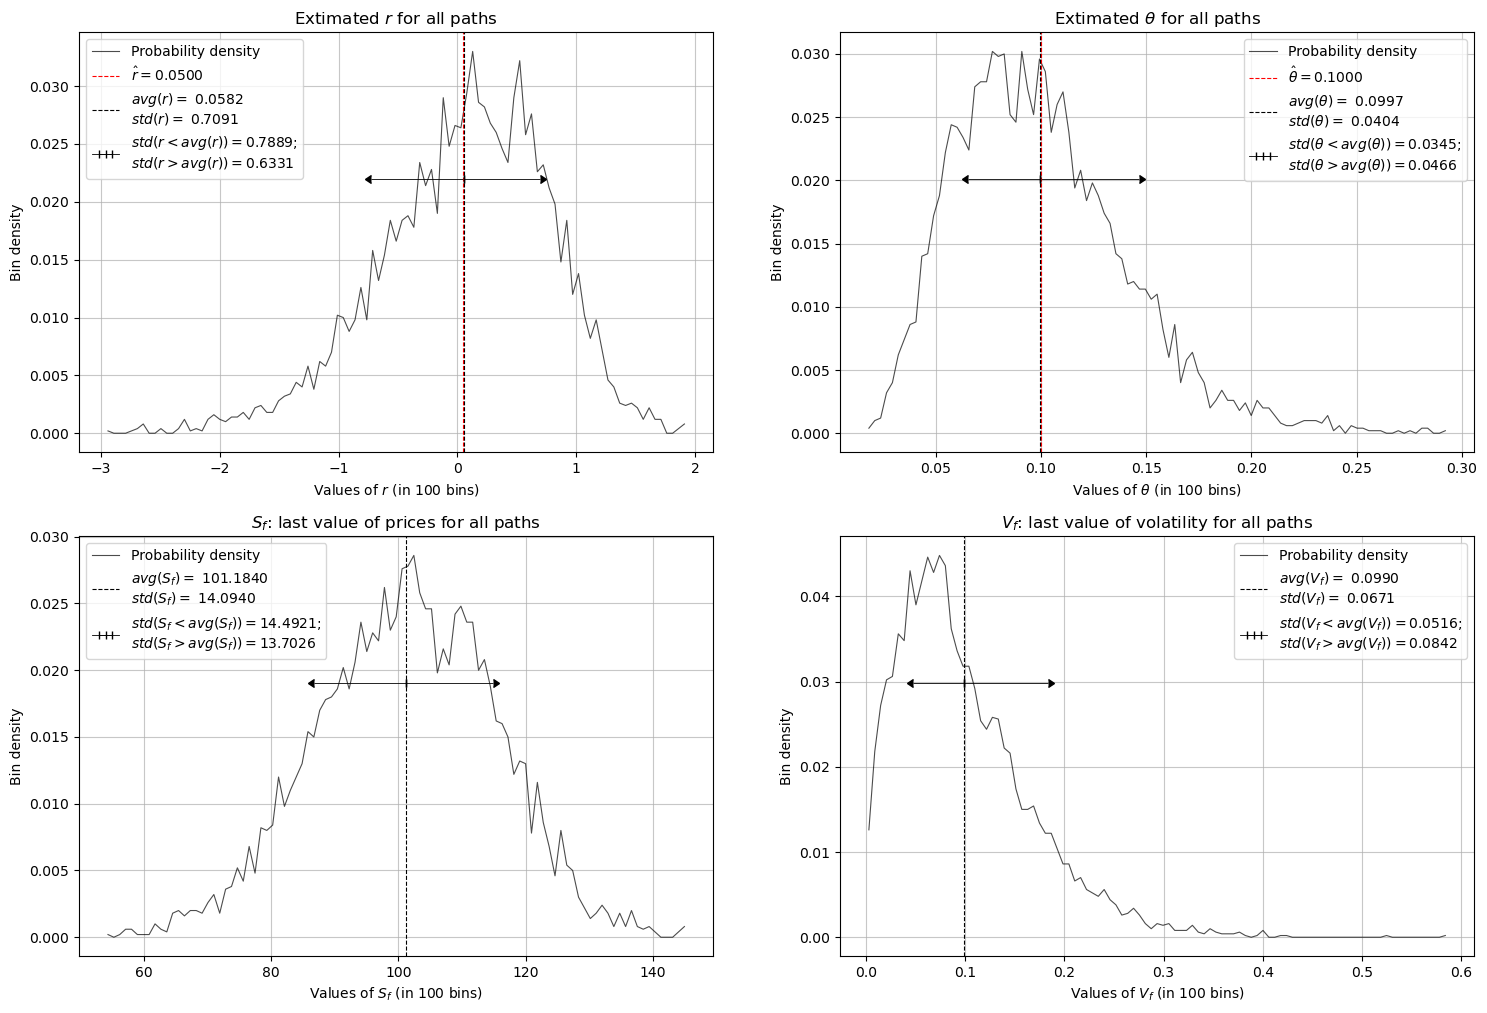

In [33]:
#----------------------------------- displaying metrics
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plot_distr(paths_r, var_true=TRUE_R, var_name='r', title='Extimated $r$ for all paths')
plt.subplot(2,2,2)
plot_distr(paths_theta, var_true=TRUE_THETA, var_name='\\theta', title='Extimated $\\theta$ for all paths')
plt.subplot(2,2,3)
plot_distr(paths_Sf, var_name='S_f', title='$S_f$: last value of prices for all paths')
plt.subplot(2,2,4)
plot_distr(paths_Vf, var_name='V_f', title='$V_f$: last value of volatility for all paths')

plt.show()

# 4) Model Testing

## 4.1) Definition of testing routine

Comprehensive of internal management, data generation, metrics evaluation and plotting

In [34]:
@timer_decorator('(tot_)_paths_CV_test')
def paths_CV_test(variable_name, variable_values, nested_progressbar=False, xlabel=None):
    """
    test model parametrizations: 
        evaluate average, std and coefficient of variation for <r>, <theta>, Sf, Vf among generated paths
        this function runs the entire testing routine,
        including internal management, paths generation, metric evaluation and plotting
    
    variable name is the variable to change in the model, variable values the values it will take
    all the other parameters are the default ones on PAR and SETTING global dictionary
        so to test the model on other base parametrization, you need to change those parameters
        by default, the amount of generated paths is given by fetching a global variable N_PATHS
    
    if testing on 'theta' is requested, this will also set the values of 'V0' (to avoid biases)
      
    return None
    
    NB no checking or control is applied to passed variable_name and variable_values
        so the user must ensure that the passed name is one of the names used in PAR and SETTING
        or 'n_paths' if the variable will be the number of generated paths
    """
    ########################################### function call initialization
    to_test_nv=[(variable_name, to_test_value) for to_test_value in variable_values]
    
    if nested_progressbar:
        nested_verb_fn=lambda var_name, var_value: lambda s: tqdm(s, desc=f"generating paths for {var_name}={var_value:.3f}\r")
    else:
        nested_verb_fn=lambda n,v: lambda s: s

    res={'r':      {'CV':{},'avg':{}, 'std':{}},
         '\\theta':{'CV':{},'avg':{}, 'std':{}},
         'S_f':    {'CV':{},'avg':{}, 'std':{}},
         'V_f':    {'CV':{},'avg':{}, 'std':{}}
        } 
    
    ############################################ generating data
    for var_name, var_value in tqdm(to_test_nv, desc='generating paths and calc. metrics'):
        #------------------------------ building parameters dictionary to pass to generate_paths
        dict_nv={var_name:var_value}
        #--- some manual adjustment
        if var_name=='theta': dict_nv['V0']=var_value #'theta' and 'V0' parameters need to change together
        if var_name=='V0': dict_nv['theta']=var_value #to avoid biases (this behaviour is silent and unavoidable)
            
        #------------------------------ deciding n_paths
        if var_name=='n_paths': 
            n_paths=var_value
            dict_nv={} #because generate paths already takes n_paths as positional argument
        else: 
            n_paths=N_PATHS #<--- fetches a global variable N_PATHS (raises error if not found)
        
        #------------------------------ generating paths
        t_paths=generate_paths(n_paths, verb_fn= nested_verb_fn(var_name, var_value), **dict_nv)
        
        #------------------------------ evaluating metrics and storing results in res dictionary
    #     print("evaluating metrics..."+" "*50, end='\r')
        res['r']['CV'][var_value],       res['r']['avg'][var_value]      ,res['r']['std'][var_value]      =\
        paths2metric_CV_r(t_paths) #<---- since r calc. can be slow, this provide a better implementation
#         paths2metric_CV(t_paths, 'S', get_r)
        res['\\theta']['CV'][var_value], res['\\theta']['avg'][var_value],res['\\theta']['std'][var_value]=\
        paths2metric_CV(t_paths, 'V', get_theta)
        res['S_f']['CV'][var_value],     res['S_f']['avg'][var_value]    ,res['S_f']['std'][var_value]    =\
        paths2metric_CV(t_paths, 'S', lambda sequence : sequence[-1])
        res['V_f']['CV'][var_value],     res['V_f']['avg'][var_value]    ,res['V_f']['std'][var_value]    =\
        paths2metric_CV(t_paths, 'V', lambda sequence : sequence[-1])
        del t_paths #releases memory
    
    ############################################ visualization
    
    #--------------------------- print parameters
    #--- some manual adjustment
    if variable_name=='theta': variable_name=['theta','V0'] #'theta' and 'V0' parameters need to change together
    if variable_name=='V0':    variable_name=['V0','theta'] #to avoid biases (this behaviour is silent and unavoidable)
    print()
    print(f"testing model for {variable_name} in {variable_values}")
    print_system(to_test=variable_name)
    #--------------------------- show plots
    n_row=3
    n_col=2
    for k, (metric_name, value_dict) in enumerate(res.items()):
        CV =value_dict['CV']
        avg=value_dict['avg']
        std=value_dict['std']

        if k%2==0: #plot index management 
            if k: plt.show() #(sketchy but it works)
            plt.figure(figsize=(18,6))    
        k=k%2 
        k+=1   
        
        #---------------------- plotting averages
        plt.subplot(n_row, n_col, k) 
        plt.title(f"Extimated ${metric_name}$: avg (black) std (yellow) and coefficient of variation (magenta)")
        plt.plot(list(avg.keys()), list(avg.values()), 'k-o')
#         plt.xlabel(f"{variable_name}")
        plt.ylabel(f"$avg({metric_name})$")
        plt.grid(visible=True, alpha=0.6)
        
        plt.subplots_adjust(hspace=0.0)
        
        #---------------------- plotting standard dev
        plt.subplot(n_row, n_col, k+n_col) #plotting std one graph below
#         plt.title(f"standard deviation of ${metric_name}$")
        plt.plot(list(std.keys()), list(std.values()), 'y-o')
#         plt.xlabel(f"{variable_name}")
        plt.ylabel(f"$std({metric_name})$")
        plt.grid(visible=True, alpha=0.6)
        
        plt.subplots_adjust(hspace=0.0)
          
        #---------------------- plotting coefficient of variation
        plt.subplot(n_row, n_col, k+2*n_col) #plotting CV two graphs below
#         plt.title(f"Coefficient of variation of ${metric_name}$")
        plt.plot(list(CV.keys()), list(CV.values()), 'm-o')
        if xlabel is None: plt.xlabel(f"{variable_name}")
        else:              plt.xlabel(xlabel)
        plt.ylabel(f"$std({metric_name})/avg({metric_name})$")
        plt.grid(visible=True, alpha=0.6)
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.show()

## 4.2) Testing

In [35]:
SIZE_GRID=20

reset_timers()

generating paths and calc. metrics:   0%|          | 0/20 [00:00<?, ?it/s]


testing model for r in [0.1        0.12105263 0.14210526 0.16315789 0.18421053 0.20526316
 0.22631579 0.24736842 0.26842105 0.28947368 0.31052632 0.33157895
 0.35263158 0.37368421 0.39473684 0.41578947 0.43684211 0.45789474
 0.47894737 0.5       ]
  SYSTEM SETTINGS################
  scheme______________:_____euler
  n_iter______________:______2000

  SYSTEM PARAMETERS--------------
  rho_________________:______-0.6
  r___________________:___to_test
  k___________________:_______2.0
  theta_______________:_______0.1
  sigma_______________:______0.57
  delta_t_____________:____0.0001
  S0__________________:_____100.0
  V0__________________:_______0.1


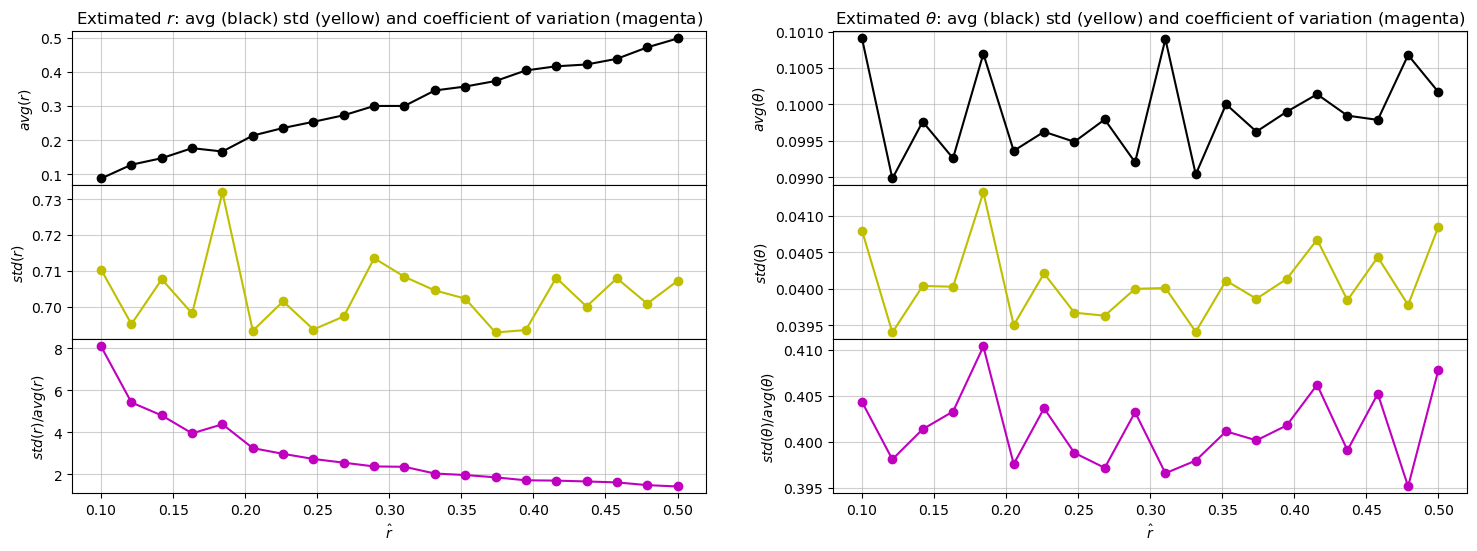

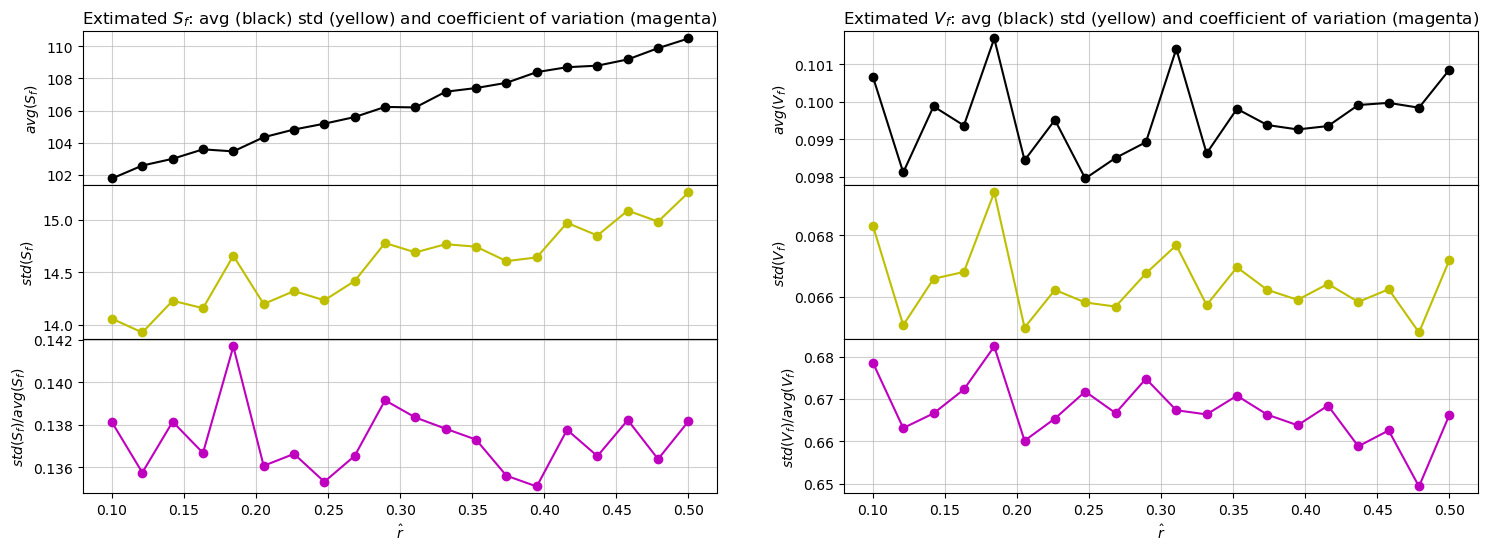

In [36]:
paths_CV_test('r', np.linspace(0.1,0.5,SIZE_GRID), xlabel='$\hat{r}$')

generating paths and calc. metrics:   0%|          | 0/20 [00:00<?, ?it/s]


testing model for ['theta', 'V0'] in [0.1        0.12105263 0.14210526 0.16315789 0.18421053 0.20526316
 0.22631579 0.24736842 0.26842105 0.28947368 0.31052632 0.33157895
 0.35263158 0.37368421 0.39473684 0.41578947 0.43684211 0.45789474
 0.47894737 0.5       ]
  SYSTEM SETTINGS################
  scheme______________:_____euler
  n_iter______________:______2000

  SYSTEM PARAMETERS--------------
  rho_________________:______-0.6
  r___________________:______0.05
  k___________________:_______2.0
  theta_______________:___to_test
  sigma_______________:______0.57
  delta_t_____________:____0.0001
  S0__________________:_____100.0
  V0__________________:___to_test


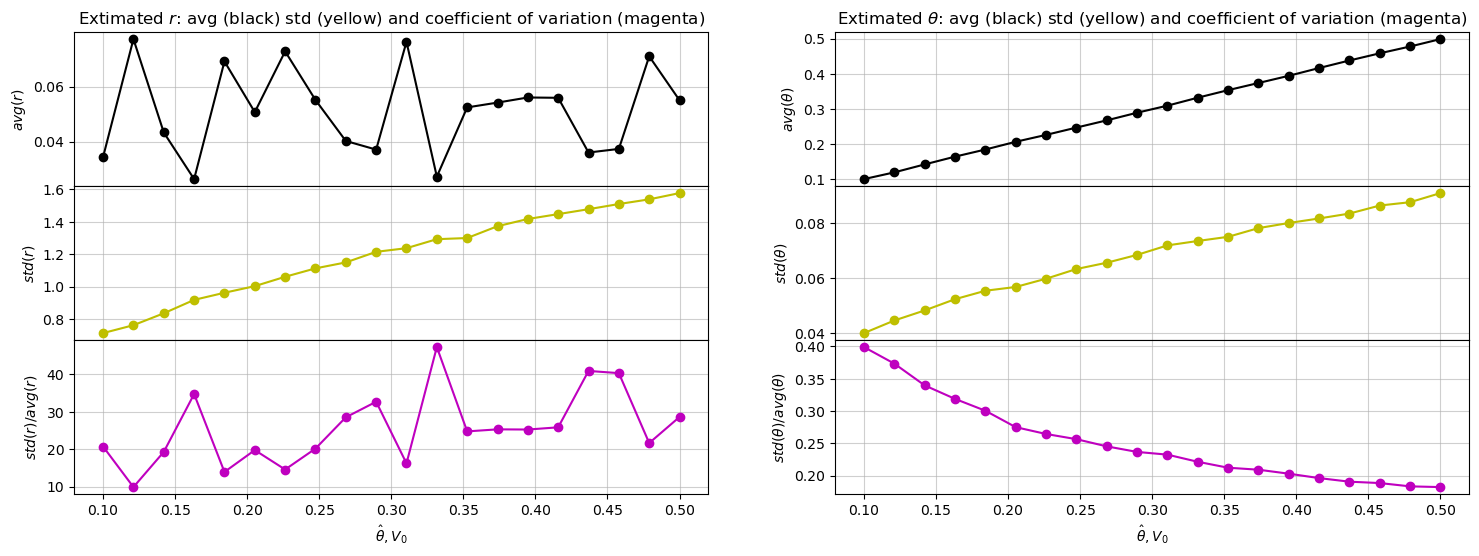

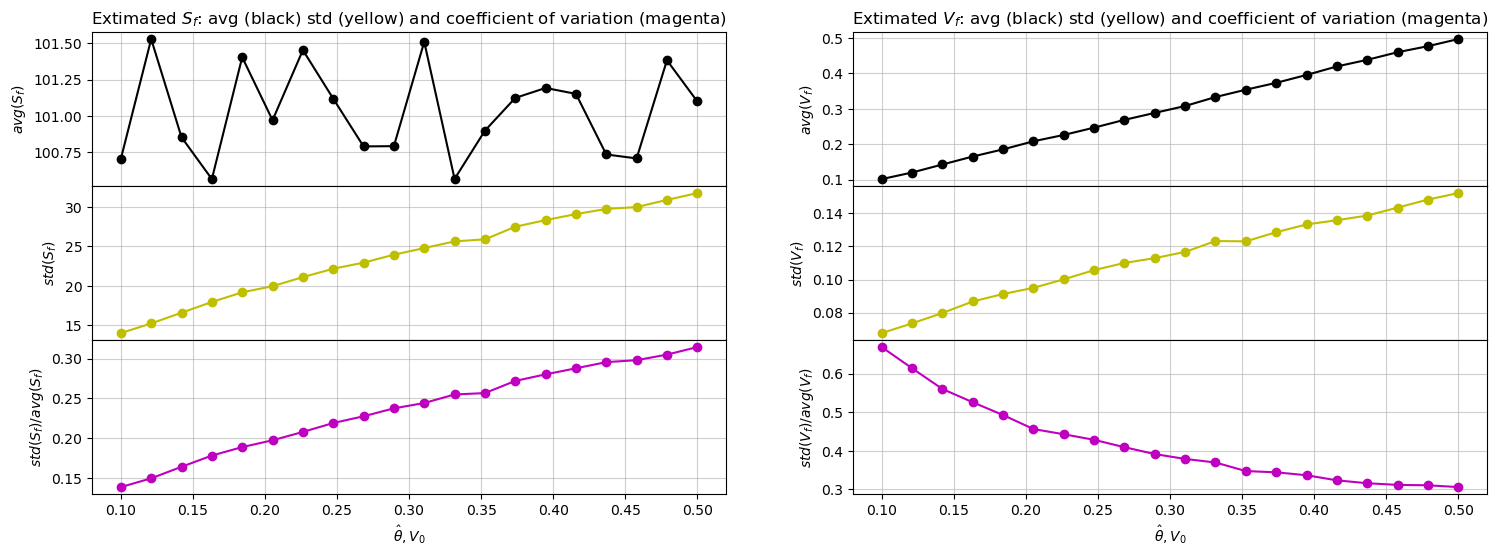

In [37]:
paths_CV_test('theta', np.linspace(0.1,0.5,SIZE_GRID), xlabel='$\hat{\\theta}, V_0$')

generating paths and calc. metrics:   0%|          | 0/20 [00:00<?, ?it/s]


testing model for sigma in [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
  SYSTEM SETTINGS################
  scheme______________:_____euler
  n_iter______________:______2000

  SYSTEM PARAMETERS--------------
  rho_________________:______-0.6
  r___________________:______0.05
  k___________________:_______2.0
  theta_______________:_______0.1
  sigma_______________:___to_test
  delta_t_____________:____0.0001
  S0__________________:_____100.0
  V0__________________:_______0.1


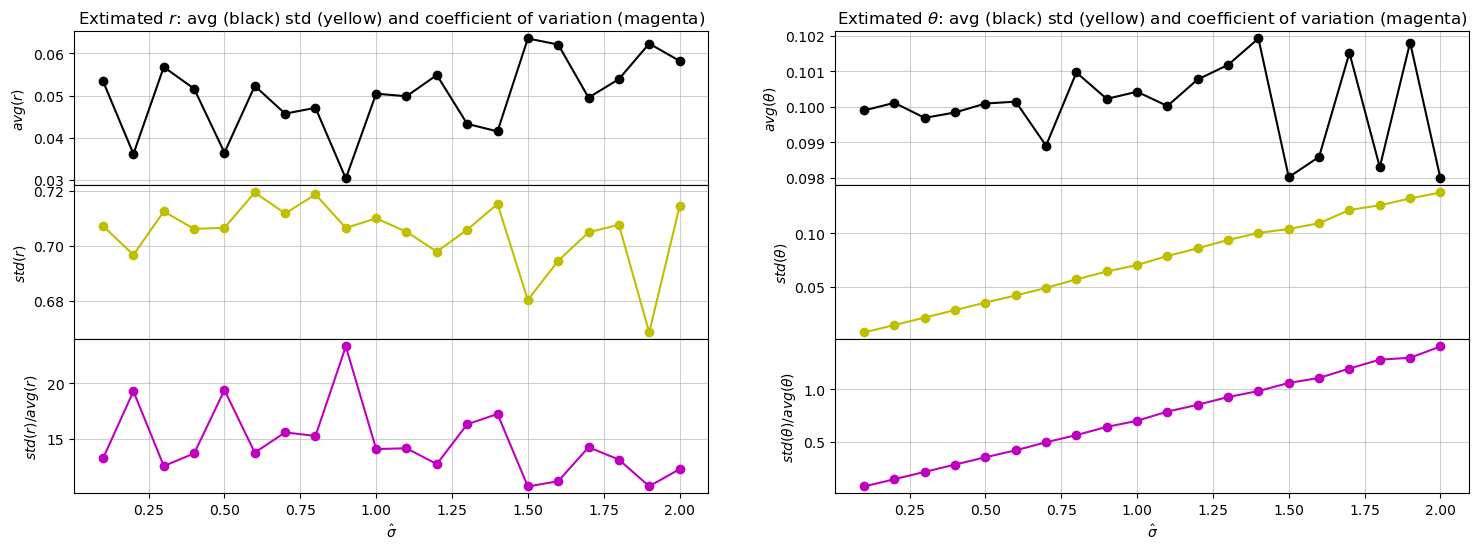

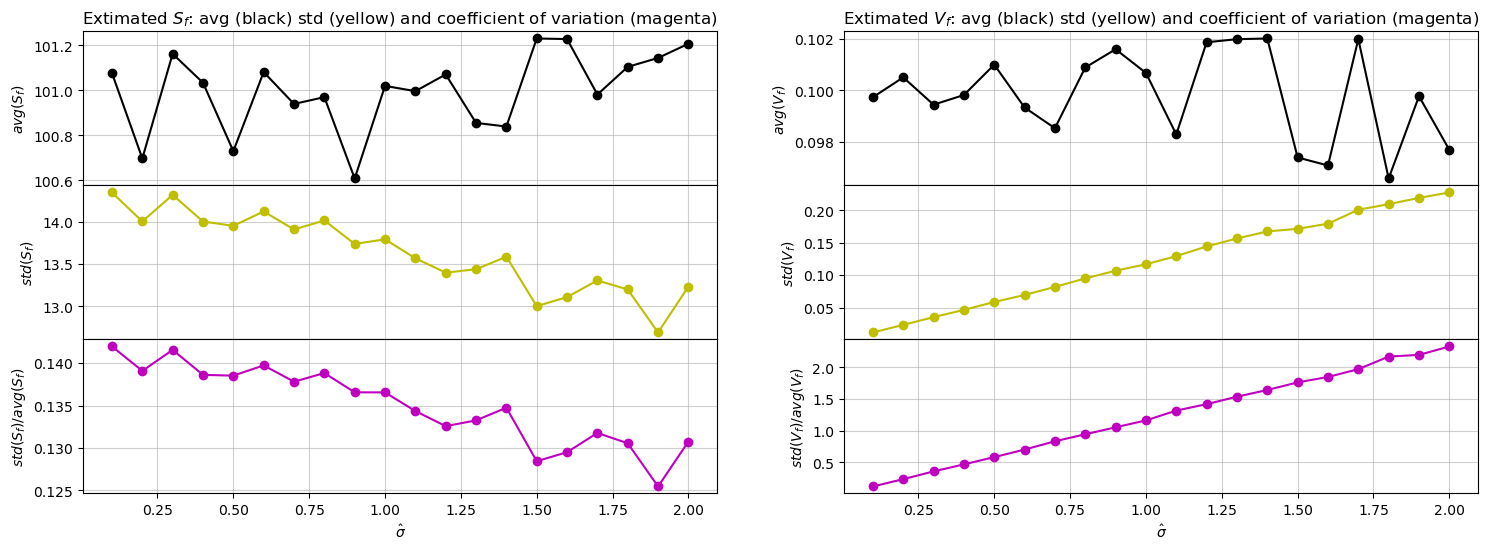

In [38]:
paths_CV_test('sigma', np.linspace(0.1,2,SIZE_GRID), xlabel='$\hat{\sigma}$')

generating paths and calc. metrics:   0%|          | 0/20 [00:00<?, ?it/s]


testing model for k in [0.01       0.11473684 0.21947368 0.32421053 0.42894737 0.53368421
 0.63842105 0.74315789 0.84789474 0.95263158 1.05736842 1.16210526
 1.26684211 1.37157895 1.47631579 1.58105263 1.68578947 1.79052632
 1.89526316 2.        ]
  SYSTEM SETTINGS################
  scheme______________:_____euler
  n_iter______________:______2000

  SYSTEM PARAMETERS--------------
  rho_________________:______-0.6
  r___________________:______0.05
  k___________________:___to_test
  theta_______________:_______0.1
  sigma_______________:______0.57
  delta_t_____________:____0.0001
  S0__________________:_____100.0
  V0__________________:_______0.1


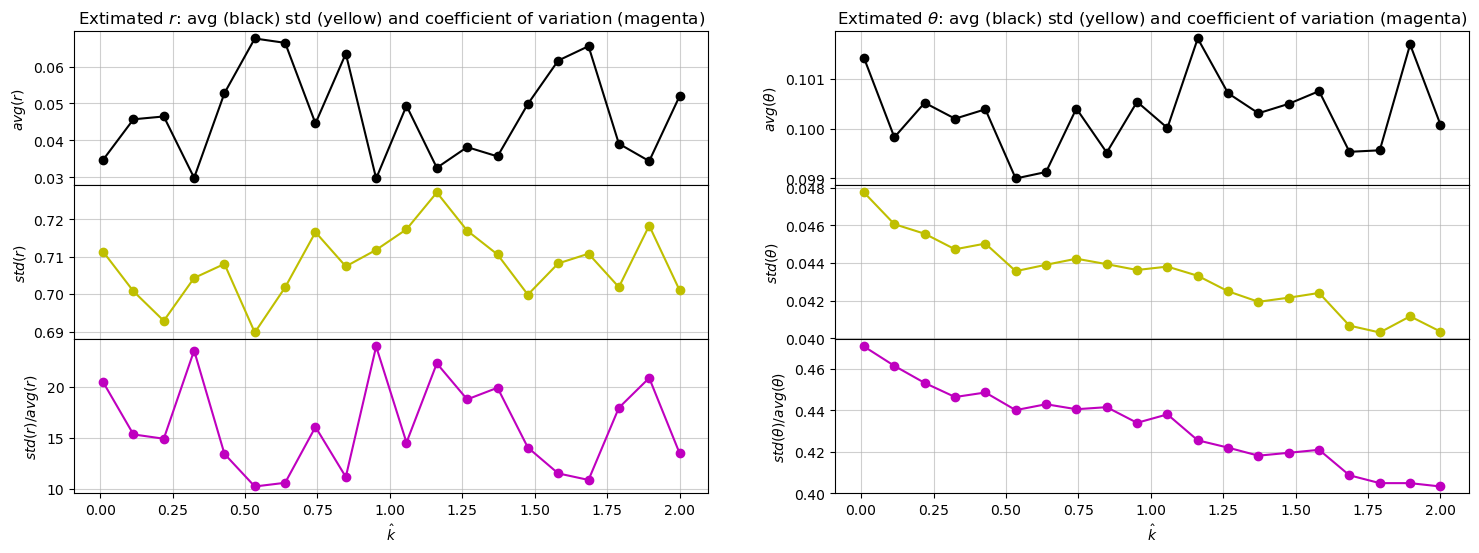

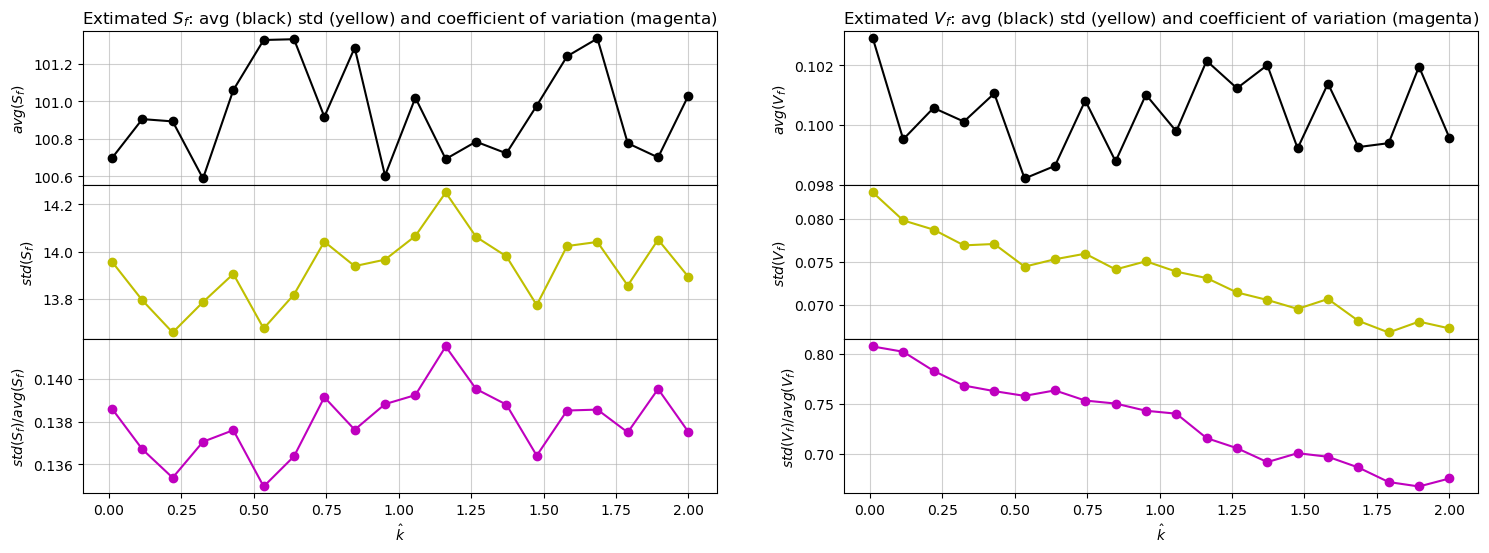

In [39]:
paths_CV_test('k', np.linspace(0.01,2.,SIZE_GRID), xlabel='$\hat{k}$')

generating paths and calc. metrics:   0%|          | 0/20 [00:00<?, ?it/s]


testing model for rho in [-0.9        -0.80526316 -0.71052632 -0.61578947 -0.52105263 -0.42631579
 -0.33157895 -0.23684211 -0.14210526 -0.04736842  0.04736842  0.14210526
  0.23684211  0.33157895  0.42631579  0.52105263  0.61578947  0.71052632
  0.80526316  0.9       ]
  SYSTEM SETTINGS################
  scheme______________:_____euler
  n_iter______________:______2000

  SYSTEM PARAMETERS--------------
  rho_________________:___to_test
  r___________________:___to_test
  k___________________:_______2.0
  theta_______________:_______0.1
  sigma_______________:______0.57
  delta_t_____________:____0.0001
  S0__________________:_____100.0
  V0__________________:_______0.1


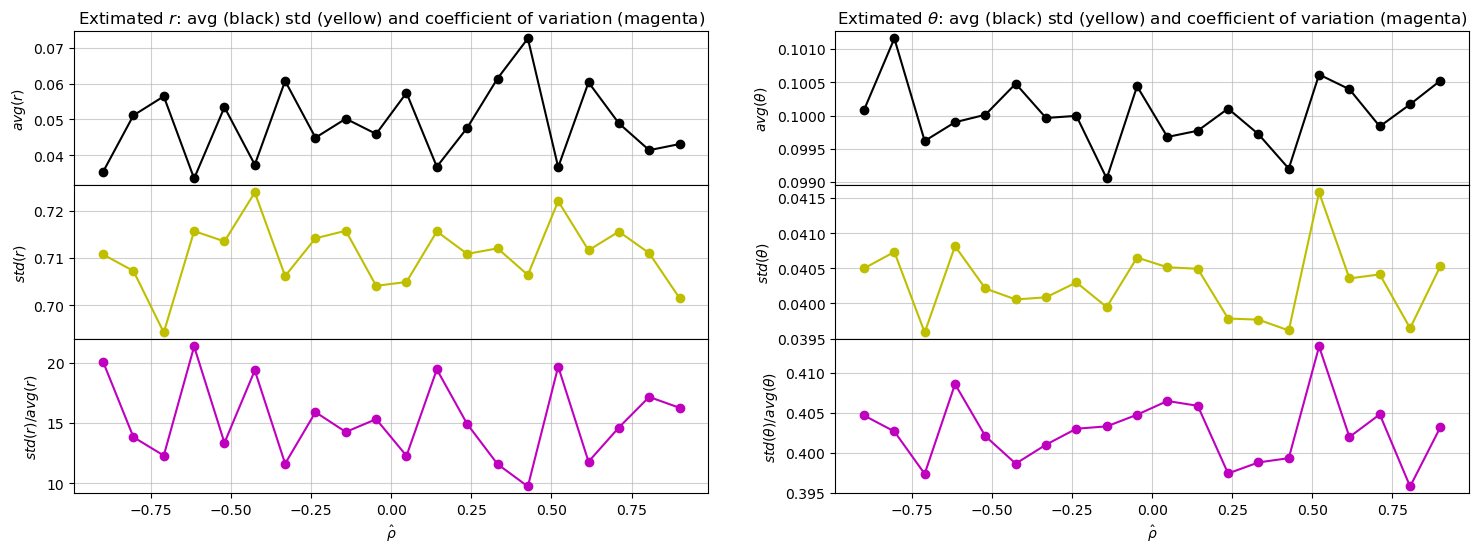

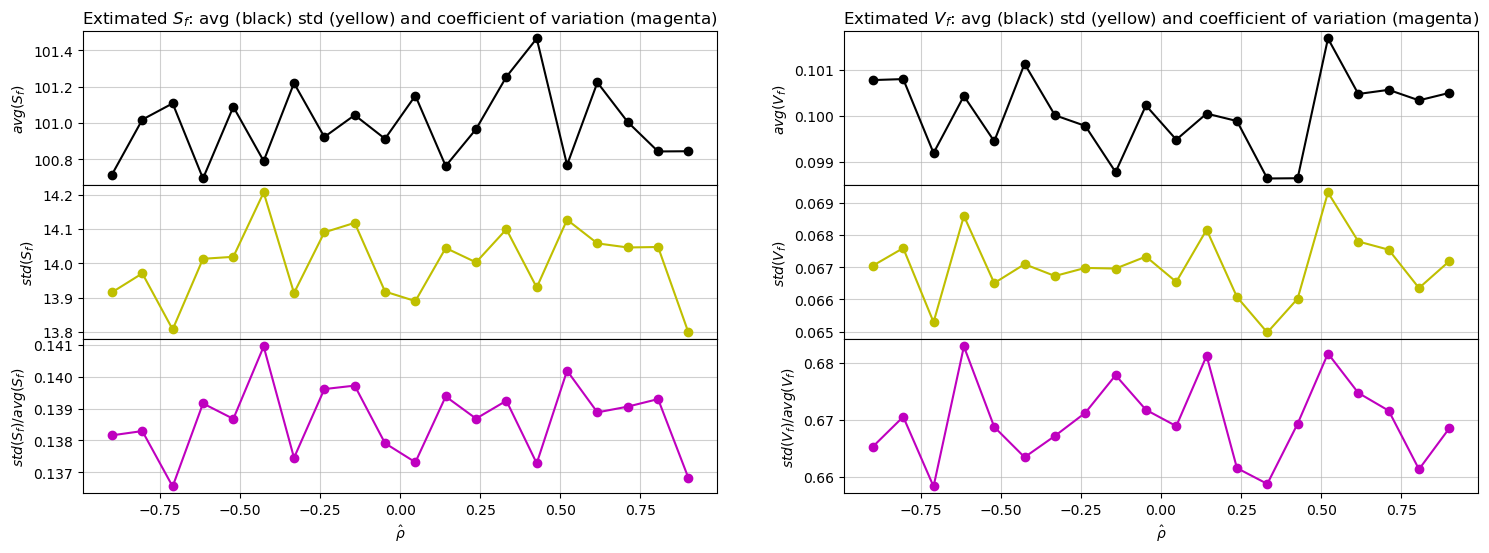

In [40]:
paths_CV_test('rho', np.linspace(-0.9,0.9,SIZE_GRID), xlabel='$\hat{\\rho}$')

generating paths and calc. metrics:   0%|          | 0/20 [00:00<?, ?it/s]


testing model for n_paths in [ 500.          736.84210526  973.68421053 1210.52631579 1447.36842105
 1684.21052632 1921.05263158 2157.89473684 2394.73684211 2631.57894737
 2868.42105263 3105.26315789 3342.10526316 3578.94736842 3815.78947368
 4052.63157895 4289.47368421 4526.31578947 4763.15789474 5000.        ]
  SYSTEM SETTINGS################
  scheme______________:_____euler
  n_iter______________:______2000

  SYSTEM PARAMETERS--------------
  rho_________________:______-0.6
  r___________________:______0.05
  k___________________:_______2.0
  theta_______________:_______0.1
  sigma_______________:______0.57
  delta_t_____________:____0.0001
  S0__________________:_____100.0
  V0__________________:_______0.1


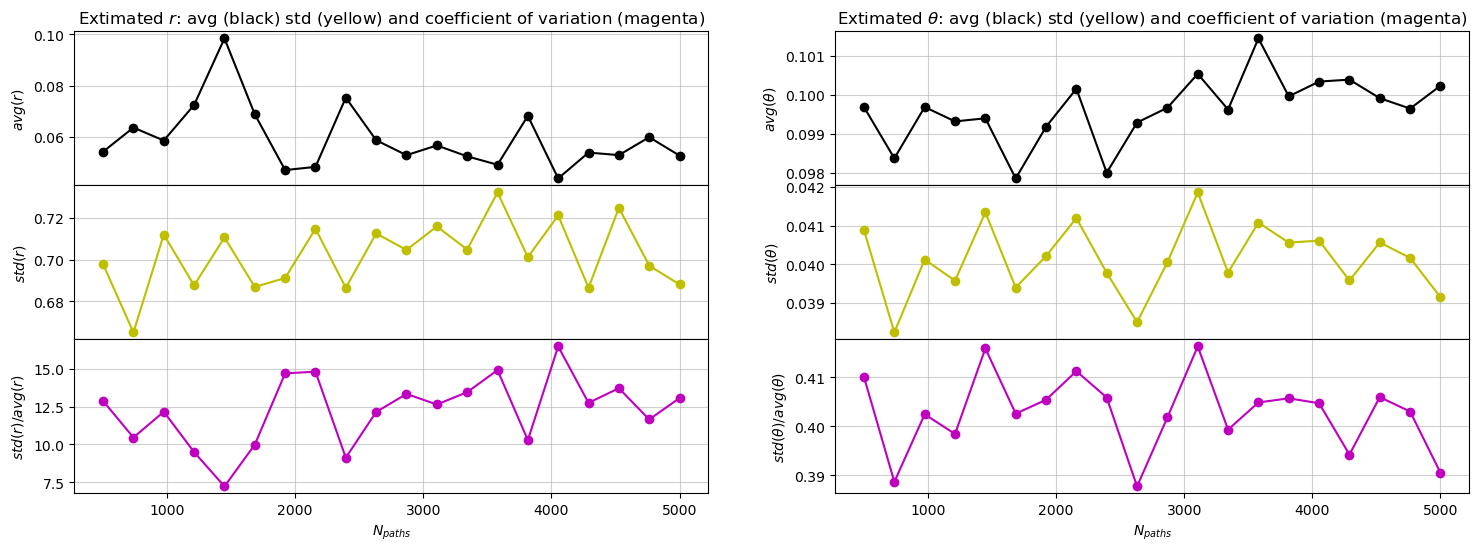

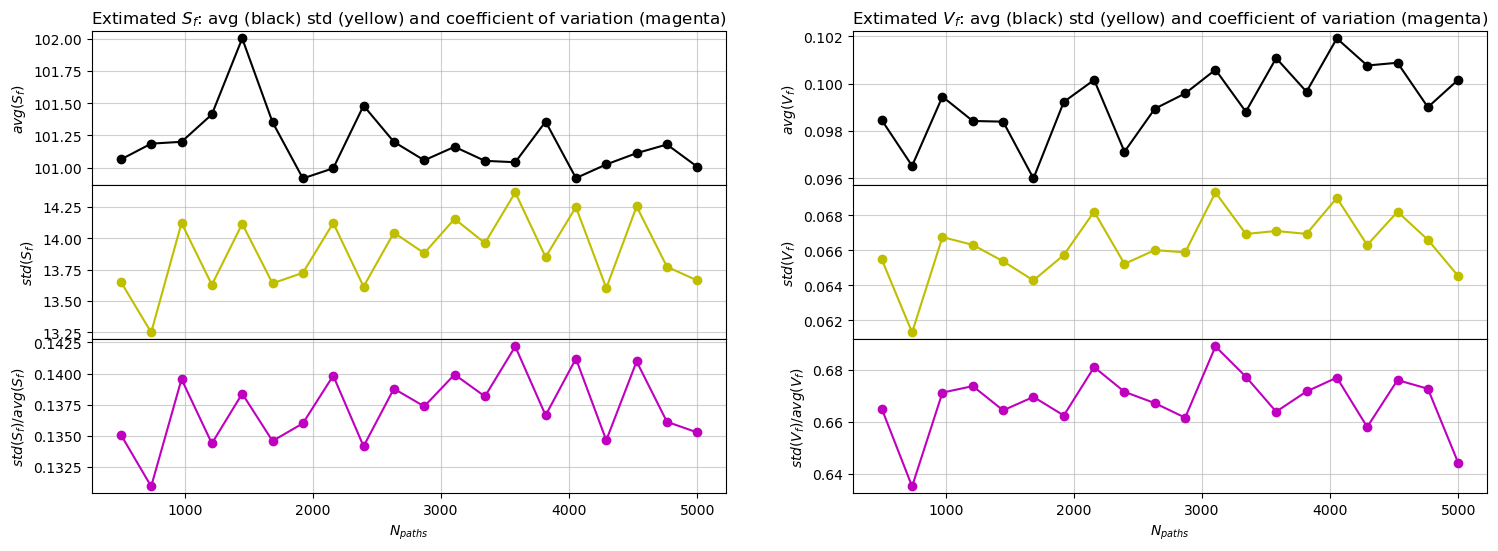

In [41]:
paths_CV_test('n_paths', np.linspace(500,5000,SIZE_GRID), xlabel='$N_{paths}$')

generating paths and calc. metrics:   0%|          | 0/20 [00:00<?, ?it/s]


testing model for n_iter in [ 300.          442.10526316  584.21052632  726.31578947  868.42105263
 1010.52631579 1152.63157895 1294.73684211 1436.84210526 1578.94736842
 1721.05263158 1863.15789474 2005.26315789 2147.36842105 2289.47368421
 2431.57894737 2573.68421053 2715.78947368 2857.89473684 3000.        ]
  SYSTEM SETTINGS################
  scheme______________:_____euler
  n_iter______________:___to_test

  SYSTEM PARAMETERS--------------
  rho_________________:______-0.6
  r___________________:___to_test
  k___________________:_______2.0
  theta_______________:_______0.1
  sigma_______________:______0.57
  delta_t_____________:____0.0001
  S0__________________:_____100.0
  V0__________________:_______0.1


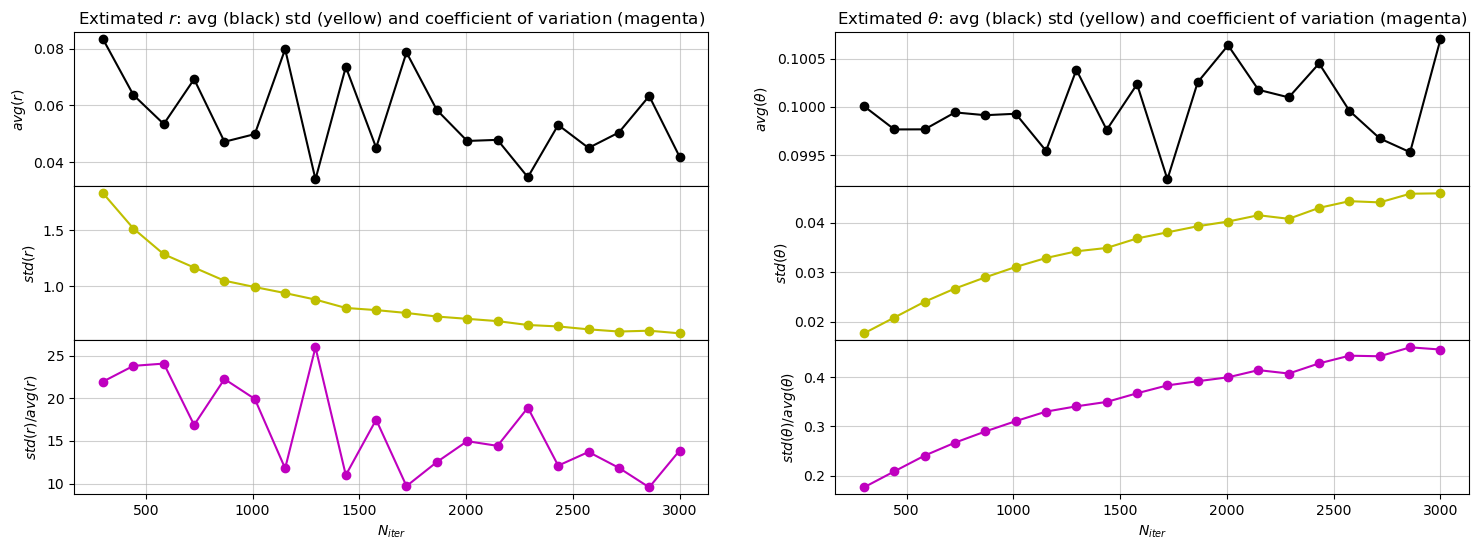

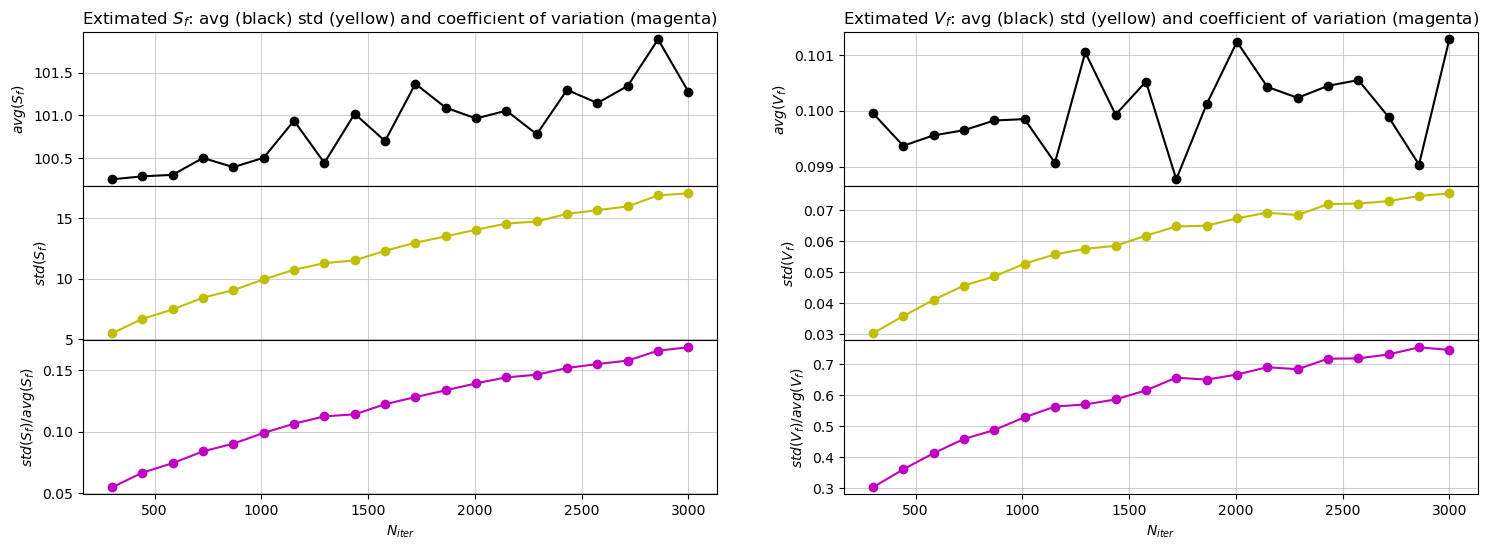

In [42]:
paths_CV_test('n_iter', np.linspace(300,3000,SIZE_GRID), xlabel='$N_{iter}$')

In [43]:

MAIN_END=time()
MAIN_TIME=MAIN_END-MAIN_START

dir_timers()
print()
print("  Total notebook time: {:.4f} sec".format(MAIN_TIME))

  Latest run timer info:

    (calc)_euler_scheme____________________________________:___________37.564008 sec
    (tech)_data_retrieving_________________________________:____________0.000031 sec
    (calc)_paths_generation_-_paths_mode___________________:__________150.150686 sec
    (mtr_)_get_theta_______________________________________:___________19.681725 sec
    (mtr_)_paths2metric____________________________________:___________21.441894 sec
    (mtr_)_get_r_-_paths_mode______________________________:___________12.572433 sec
    (mtr_)_paths2metric_CV_________________________________:___________21.723233 sec
    (mtr_)_paths2metric_CV_r_______________________________:___________12.586804 sec
    (tot_)_paths_CV_test___________________________________:__________198.367273 sec

  Total notebook time: 319.7294 sec
